In [1]:
import prodimopy.read as pread
import prodimopy.plot as pplot
import prodimopy.plot_models as ppms
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.constants import h as planck_h
from scipy.constants import k as boltzmann_k
from scipy.constants import c as speed_of_light
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise

In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

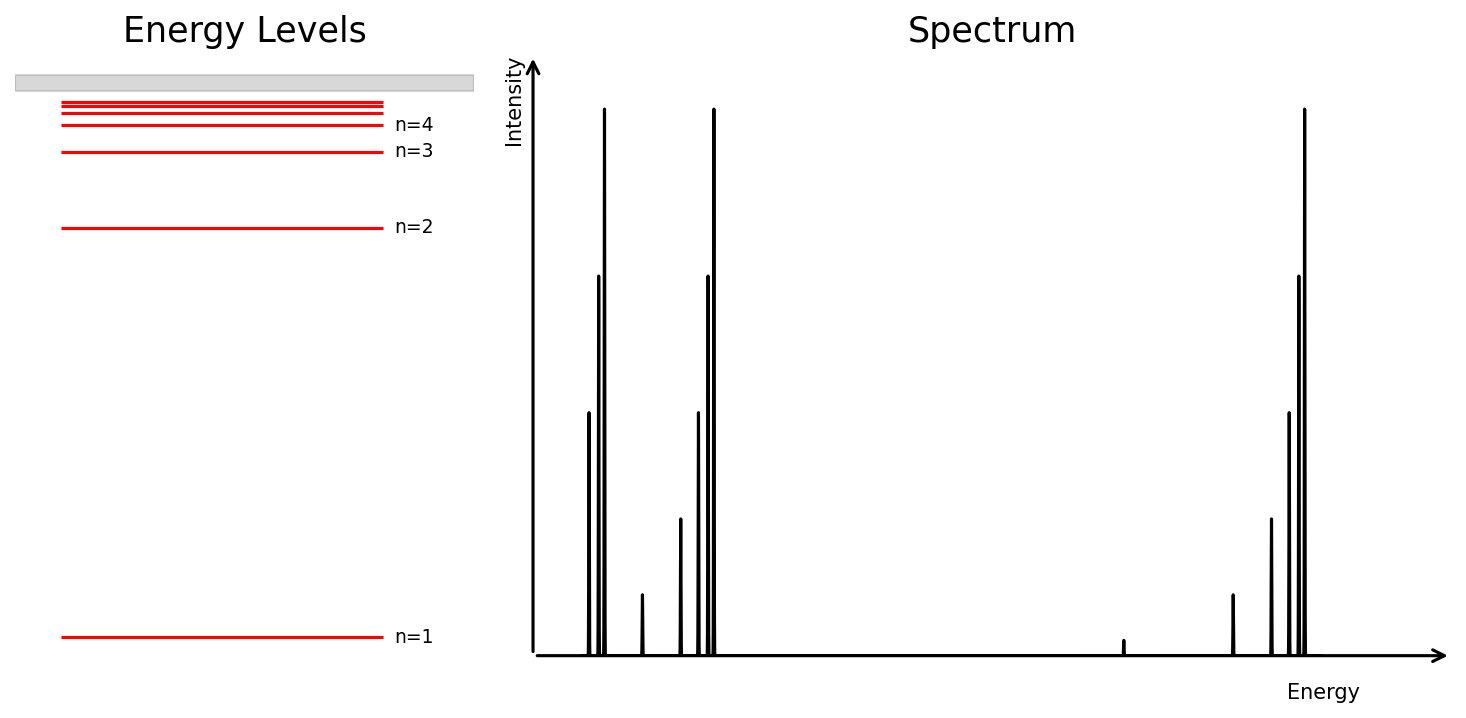

In [4]:
fig, (ax_levels, ax_spectrum) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

n = np.arange(1, 8)
ion_energy = 3
energies = -ion_energy/(n**2)+ion_energy

x_min, x_max = 0, ion_energy+0.5
y_min, y_max = 0, 1.1

kT = 300
def boltzmann(n):
    E = -ion_energy/(n**2)
    return (2*n**2) * np.exp(-E / kT)

for i, E in enumerate(energies):
    if i>7:
        break
    ax_levels.hlines(E, 0.2, 1.6, color='red')
    if i <= 3:
        ax_levels.text(1.65, E, f'n={i+1}', va='center', fontsize=9)
ax_levels.axhspan(ion_energy, ax_levels.get_ylim()[1], color='gray', alpha=0.3, label='Ionization Region')
# Energy level axis setup
ax_levels.set_xlim(0, 2)
ax_levels.set_ylim(-0.1, 3.2)
ax_levels.axis('off')
ax_levels.set_title('Energy Levels')

# Simulated spectrum (transition energies = E_excited - E_ground)
spectrum_x = []
spectrum_n = []

for i, E_g in enumerate(energies):
    for j, E_e in enumerate(energies):
        energy = E_e - E_g
        if energy>0:
            spectrum_x.append(energy)
            spectrum_n.append(boltzmann(j))
# Create Gaussian-broadened spectrum
x_vals = np.linspace(ion_energy/16, ion_energy, 100000)
y_vals = np.zeros_like(x_vals)
sigma = 0.001

for i, center in enumerate(spectrum_x):
    y_vals += spectrum_n[i]*np.exp(-0.5 * ((x_vals - center) / sigma)**2)
# Normalize
y_vals /= y_vals.max()

# Plot the spectrum
ax_spectrum.axis('off')
# x_vals = np.logspace(np.log10(1e-5), np.log10(x_max), 10000)
# Set limits manually since we removed axes
ax_spectrum.set_xlim(x_min, x_max)
ax_spectrum.set_ylim(y_min, y_max)

# X-axis arrow
ax_spectrum.annotate('', xy=(x_max, 0), xytext=(x_min, 0),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Y-axis arrow
ax_spectrum.annotate('', xy=(0, y_max), xytext=(0, y_min),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Optional: Add labels
ax_spectrum.text(x_max * 0.9, -0.05, 'Energy', ha='right', va='top', fontsize=10)
ax_spectrum.text(-x_max * 0.01, y_max, 'Intensity', ha='right', va='top', rotation='vertical', fontsize=10)

ax_spectrum.plot(x_vals, y_vals, color='black')
ax_spectrum.set_title('Spectrum')

plt.tight_layout()
plt.savefig('Figures/ElecSpectrum.pdf', bbox_inches='tight')
plt.show()

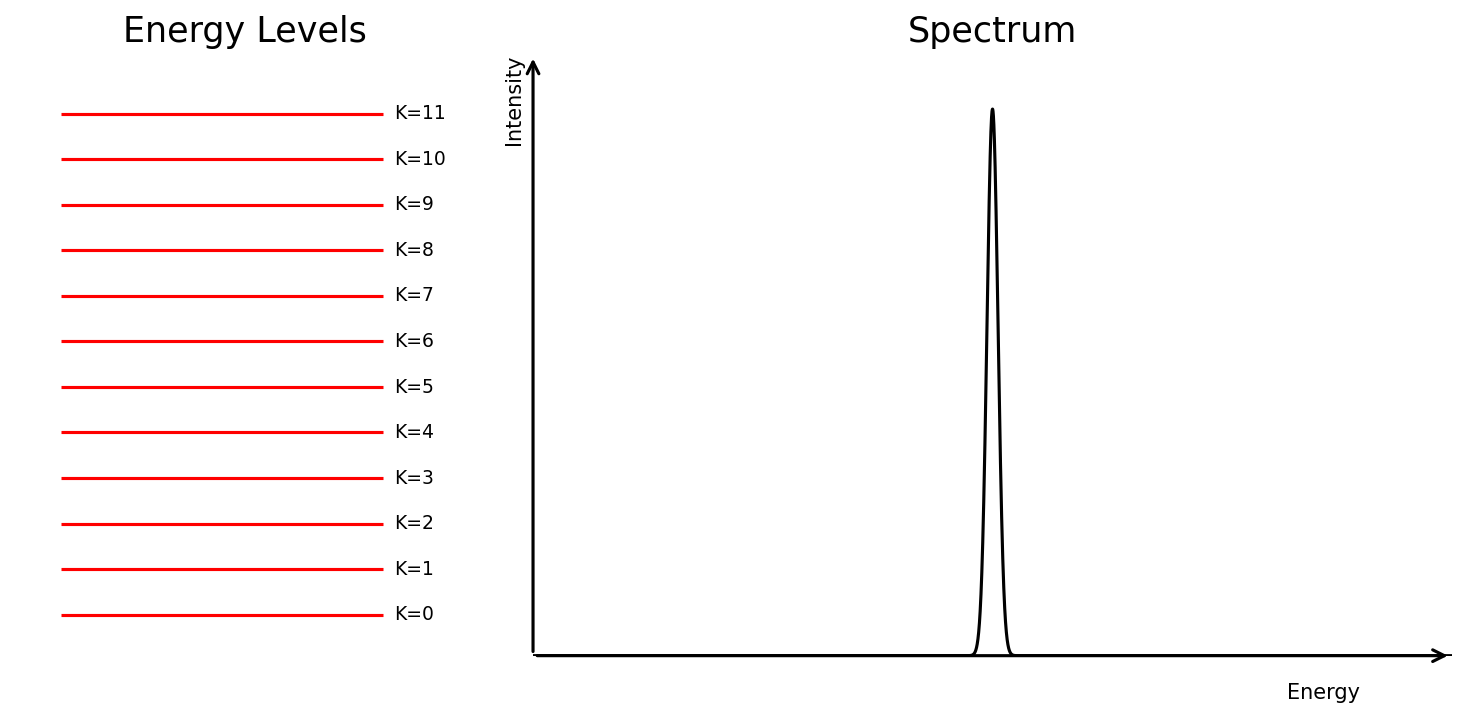

In [5]:
fig, (ax_levels, ax_spectrum) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

x_min, x_max = 0, 0.5
y_min, y_max = 0, 1.1

n = np.arange(0, 12)
ion_energy =0.25
energies = ion_energy*(n+1/2)

for i, E in enumerate(energies):
    ax_levels.hlines(E, 0.2, 1.6, color='red')
    if i >= 0:
        ax_levels.text(1.65, E, f'K={i}', va='center', fontsize=9)
# Energy level axis setup
ax_levels.set_xlim(0, 2)
ax_levels.set_ylim(-0.1, 3.2)
ax_levels.axis('off')
ax_levels.set_title('Energy Levels')

spectrum_x = []
spectrum_y = []

for i, E_g in enumerate(energies):
    for j, E_e in enumerate(energies):
        energy = E_e - E_g
        if energy>0 and abs(i-j)<=1:
            spectrum_x.append(energy)
            spectrum_y.append(1)  # all transitions equally strong for simplicity

# Create Gaussian-broadened spectrum
x_vals = np.linspace(x_min, x_max, 10000)
y_vals = np.zeros_like(x_vals)
sigma = 0.003

for center in spectrum_x:
    y_vals += np.exp(-0.5 * ((x_vals - center) / sigma)**2)

# Normalize
y_vals /= y_vals.max()

# Plot the spectrum
ax_spectrum.axis('off')

# Set limits manually since we removed axes
ax_spectrum.set_xlim(x_min, x_max)
ax_spectrum.set_ylim(y_min, y_max)

# X-axis arrow
ax_spectrum.annotate('', xy=(x_max, 0), xytext=(x_min, 0),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Y-axis arrow
ax_spectrum.annotate('', xy=(0, y_max), xytext=(0, y_min),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Optional: Add labels
ax_spectrum.text(x_max * 0.9, -0.05, 'Energy', ha='right', va='top', fontsize=10)
ax_spectrum.text(-x_max * 0.01, y_max, 'Intensity', ha='right', va='top', rotation='vertical', fontsize=10)

ax_spectrum.plot(x_vals, y_vals, color='black')
ax_spectrum.set_title('Spectrum')

plt.tight_layout()
plt.savefig('Figures/VibSpectrum.pdf', bbox_inches='tight')
plt.show()

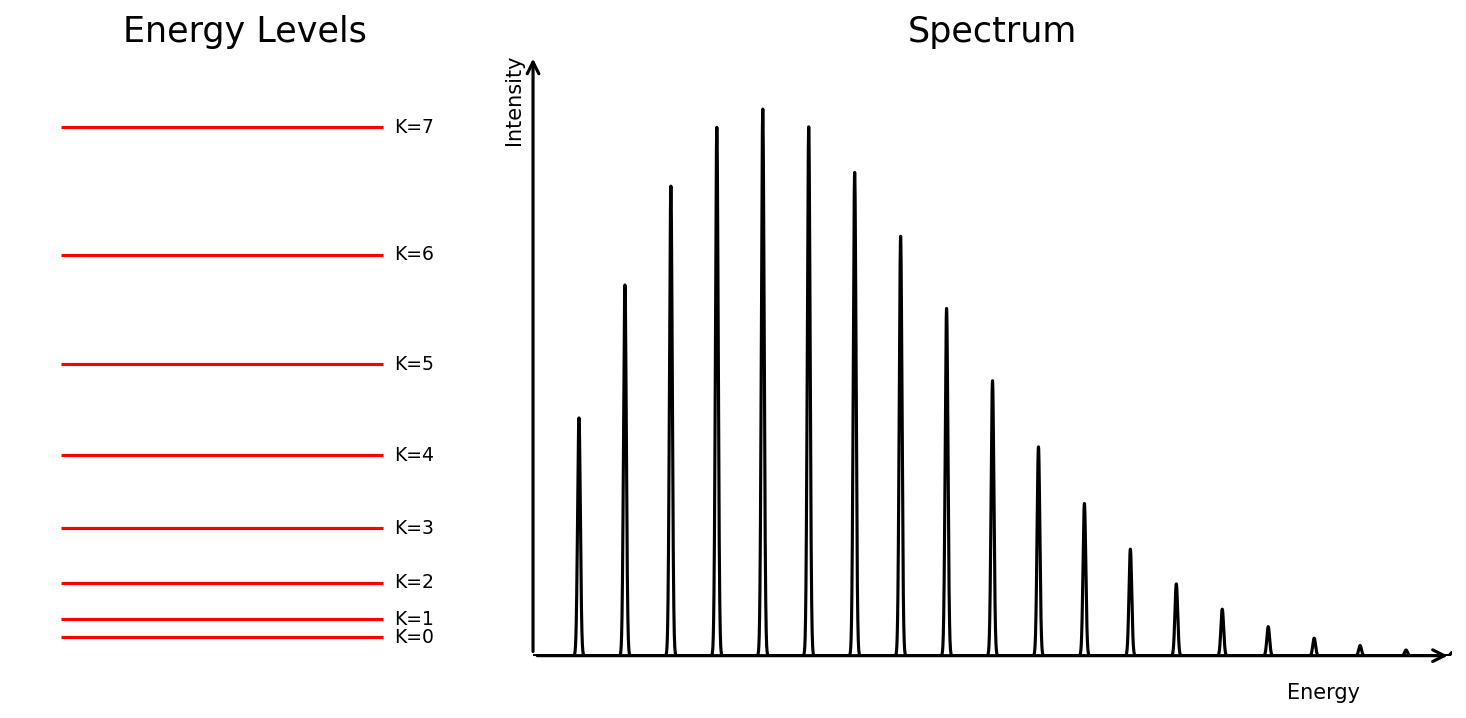

In [6]:
fig, (ax_levels, ax_spectrum) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

x_min, x_max = 0, 2
y_min, y_max = 0, 1.1

n = np.arange(0, 30)
ion_energy =0.05
energies = ion_energy*n*(n+1)
kT = 3
def boltzmann(K):
    E = ion_energy * K * (K + 1)
    return (2*K + 1) * np.exp(-E / kT)

for i, E in enumerate(energies):
    if i > 7:
        break
    ax_levels.hlines(E, 0.2, 1.6, color='red')
    if i >= 0:
        ax_levels.text(1.65, E, f'K={i}', va='center', fontsize=9)
# Energy level axis setup
ax_levels.set_xlim(0, 2)
ax_levels.set_ylim(-0.1, 3.2)
ax_levels.axis('off')
ax_levels.set_title('Energy Levels')

spectrum_x = []
spectrum_K = []

for i, E_g in enumerate(energies):
    for j, E_e in enumerate(energies):
        energy = E_e - E_g
        if energy>0 and abs(i-j)<=1:
            spectrum_x.append(energy)
            spectrum_K.append(boltzmann(j))  # all transitions equally strong for simplicity

# Create Gaussian-broadened spectrum
x_vals = np.linspace(x_min, x_max, 10000)
y_vals = np.zeros_like(x_vals)
sigma = 0.003

for i, center in enumerate(spectrum_x):
    y_vals +=spectrum_K[i]*np.exp(-0.5 * ((x_vals - center) / sigma)**2)

# Normalize
y_vals /= y_vals.max()

# Plot the spectrum
ax_spectrum.axis('off')

# Set limits manually since we removed axes
ax_spectrum.set_xlim(x_min, x_max)
ax_spectrum.set_ylim(y_min, y_max)

# X-axis arrow
ax_spectrum.annotate('', xy=(x_max, 0), xytext=(x_min, 0),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Y-axis arrow
ax_spectrum.annotate('', xy=(0, y_max), xytext=(0, y_min),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Optional: Add labels
ax_spectrum.text(x_max * 0.9, -0.05, 'Energy', ha='right', va='top', fontsize=10)
ax_spectrum.text(-x_max * 0.01, y_max, 'Intensity', ha='right', va='top', rotation='vertical', fontsize=10)

ax_spectrum.plot(x_vals, y_vals, color='black')
ax_spectrum.set_title('Spectrum')

plt.tight_layout()
plt.savefig('Figures/RoSpectrum.pdf', bbox_inches='tight')
plt.show()

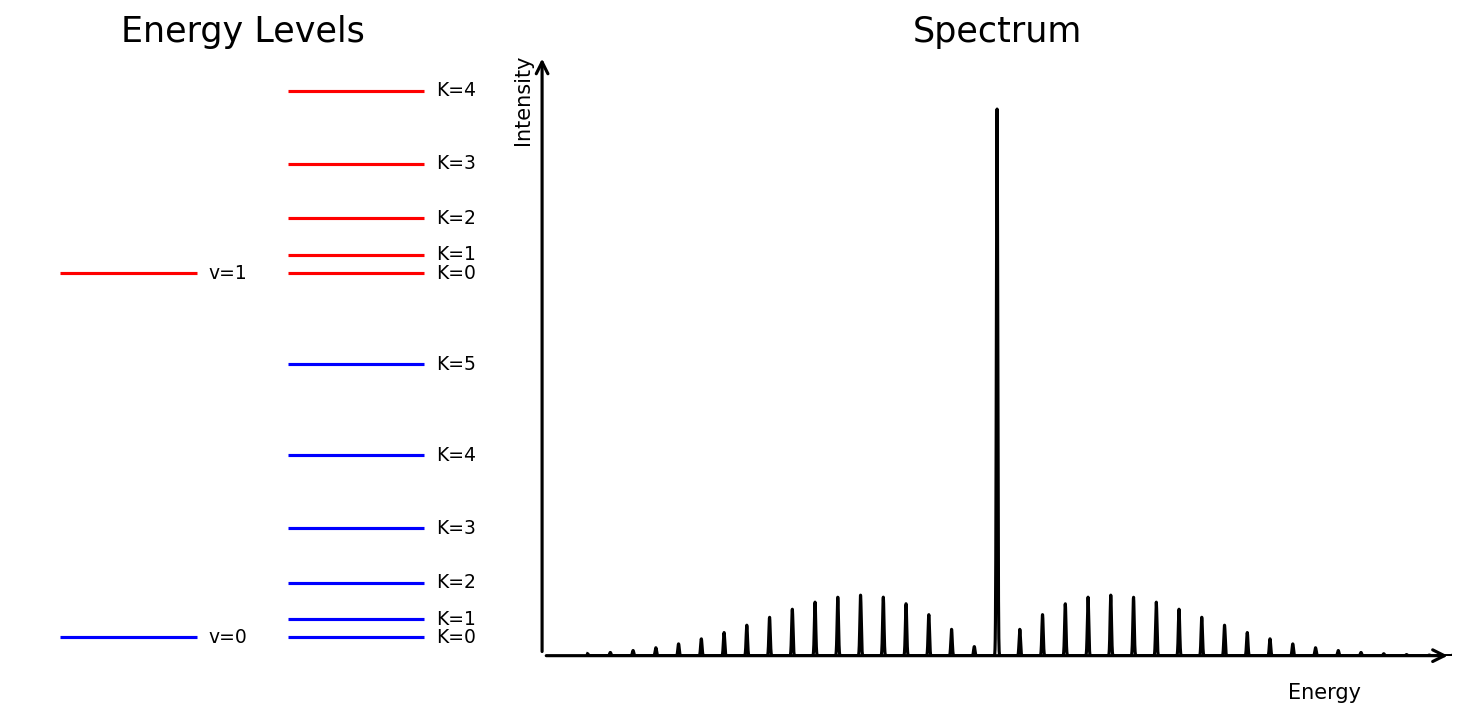

In [7]:
fig, (ax_levels, ax_spectrum) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

energy_vib = 2
n = np.arange(0, 40)
ion_energy =0.05
vibrational_levels_ground = ion_energy*n*(n+1)
vibrational_levels_excited = vibrational_levels_ground+energy_vib
kT = 3
def boltzmann(J):
    E = ion_energy * J * (J + 1)
    return (2*J + 1) * np.exp(-E / kT)

# Plot ground state vibrational levels
for i, E in enumerate(vibrational_levels_ground):
    if i == 0:
        ax_levels.hlines(E, 0.2, 0.8, color='blue')
        ax_levels.text(0.85, E, f'v={0}', va='center', fontsize=9)
    if i > 5:
        break
    ax_levels.hlines(E, 1.2, 1.8, color='blue')
    ax_levels.text(1.85, E, f'K={i}', va='center', fontsize=9)

# Plot excited state vibrational levels
for i, E in enumerate(vibrational_levels_excited):
    if i == 0:
        ax_levels.hlines(E, 0.2, 0.8, color='red')
        ax_levels.text(0.85, E, f'v={1}', va='center', fontsize=9)
    if i > 4:
        break
    ax_levels.hlines(E, 1.2, 1.8, color='red')
    ax_levels.text(1.85, E, f'K={i}', va='center', fontsize=9)

# Energy level axis setup
ax_levels.set_xlim(0, 2)
ax_levels.set_ylim(-0.1, 3.2)
ax_levels.axis('off')
ax_levels.set_title('Energy Levels')

# Simulated spectrum (transition energies = E_excited - E_ground)
spectrum_x = []
spectrum_J = []

for i, E_g in enumerate(vibrational_levels_ground):
    for j, E_e in enumerate(vibrational_levels_excited):
        energy = E_e - E_g
        if energy>0 and abs(i-j)<=1:
            spectrum_x.append(energy)
            spectrum_J.append(boltzmann(j))

# Create Gaussian-broadened spectrum
x_vals = np.linspace(0.2, 5, 10000)
y_vals = np.zeros_like(x_vals)
sigma = 0.003

for i, center in enumerate(spectrum_x):
    y_vals += spectrum_J[i]*np.exp(-0.5 * ((x_vals - center) / sigma)**2)

# Normalize
y_vals /= y_vals.max()

# Plot the spectrum
ax_spectrum.axis('off')
x_min, x_max = 0, 2*energy_vib
y_min, y_max = 0, 1.1

# Set limits manually since we removed axes
ax_spectrum.set_xlim(x_min, x_max)
ax_spectrum.set_ylim(y_min, y_max)

# X-axis arrow
ax_spectrum.annotate('', xy=(x_max, 0), xytext=(x_min, 0),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Y-axis arrow
ax_spectrum.annotate('', xy=(0, y_max), xytext=(0, y_min),
                     arrowprops=dict(arrowstyle='->', linewidth=1.5, color='black'))

# Optional: Add labels
ax_spectrum.text(x_max * 0.9, -0.05, 'Energy', ha='right', va='top', fontsize=10)
ax_spectrum.text(-x_max * 0.01, y_max, 'Intensity', ha='right', va='top', rotation='vertical', fontsize=10)

ax_spectrum.plot(x_vals, y_vals, color='black')
ax_spectrum.set_title('Spectrum')

plt.tight_layout()
plt.savefig('Figures/RoVibSpectrum.pdf', bbox_inches='tight')
plt.show()

In [8]:
colors = {'atomic': 'tomato', 'C2H2': 'yellow', 'CH4': 'mediumorchid', 'CO': 'red', 'CO2': 'limegreen', 'H2O': 'dodgerblue',
          'HCN': 'orange', 'NH3': 'cyan', 'NO': 'gold', 'OH': 'magenta'}

In [9]:
with open('ProDiMoData1000_N.pkl', 'rb') as f:
    models = pickle.load(f)

PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...


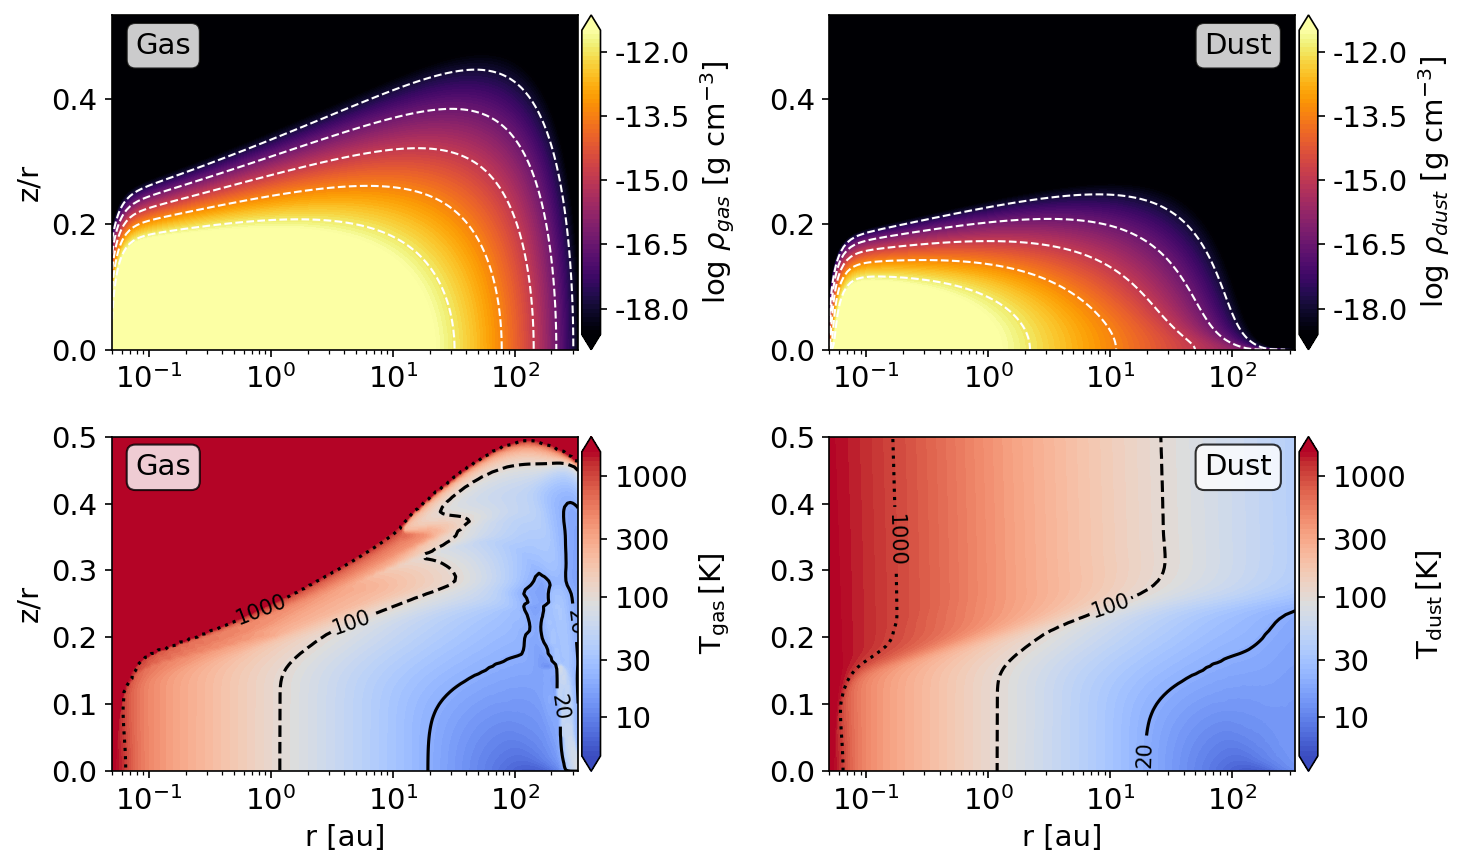

In [10]:
for i,model in enumerate(models):
    if i != 12:
        continue
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(2, 2)
    axs = axs.flatten()
    pp = pplot.Plot(None)
    # This can be very useful is one wants to have multiple plots with a similar style
    # Here we also change the color map
    constyle = {"cmap": "inferno", "extend": "both", "cb_format": "%.1f", "zlim": [3.e-19, 3.e-12]}

    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0], **constyle)
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1], **constyle)

    # we do not need the z/r axis in the second plot

    # place some text boxes on the plots
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    tcont=pplot.Contour(model.tg, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    #tcont.label_locations=[(100,100),(55,5),(40,5)]
    # another contour, a simple one
    avcont=pplot.Contour(model.AV,[1.0],colors="black")

    cbticks=[10,30,100,300,1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[2],fig=fig, cmap='coolwarm')
    tcont=pplot.Contour(model.td, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[3],fig=fig, cmap='coolwarm')
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[2].text(0.05, 0.95, "Gas", transform=axs[2].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[3].text(0.95, 0.95, "Dust", transform=axs[3].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    axs[1].set_ylabel("")
    axs[3].set_ylabel("")
    axs[1].set_xlabel("")
    axs[0].set_xlabel("")
    plt.tight_layout()
plt.savefig('Figures/DensityTemperature.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont_grid ...
[1e-15, 0.001]


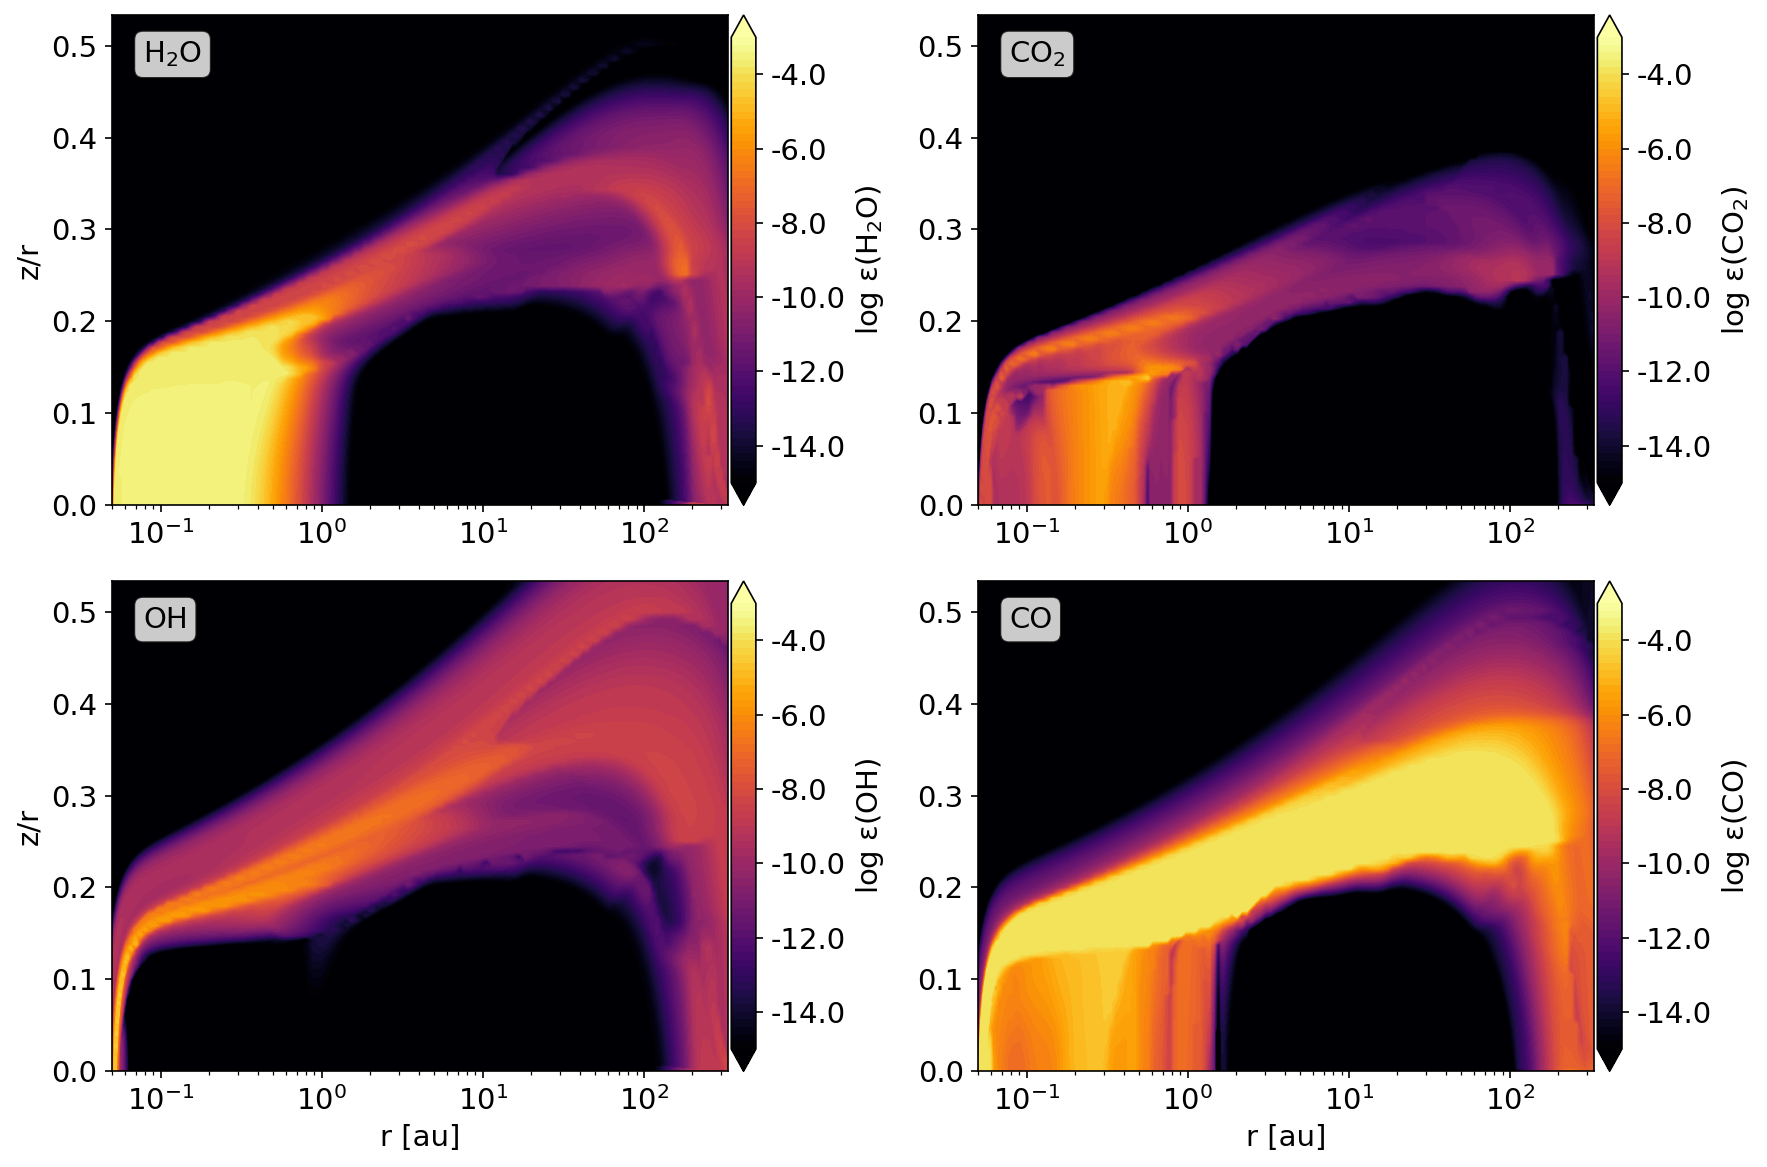

In [11]:
species = ["H2O","CO2" ,"OH", "CO"]
for i,model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp=pplot.Plot(None)

    tcont=pplot.Contour(model.tg, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=14,label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont=pplot.Contour(model.AV,[1.0],colors="black")

    cbticks=[10,30,100,300,1000]
    fig =pp.plot_abuncont_grid(model,
                          species,nrows=2, ncols=2,
                          zlim=[1.e-15,1.e-3],extend="both",contour=False, cmap='inferno')

    # _ =pp.plot_abuncont_grid(model,
    #                       ["HCN#","NH3#","NO#","H2O#"],nrows=2, ncols=2,
    #                       zlim=[1.e-8,1.e-3],extend="both",contour=False, cmap='inferno')
fig.set_size_inches(12, 8)
species = [r"H$_2\mathrm{O}$",r"CO$_2$" ,"OH", "CO"]
for i, ax in enumerate(fig.get_axes()):
    if i>=4:
        break
    ax.text(0.05, 0.95, species[i], transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    if i in [0,1]:
        ax.set_xlabel('')
    if i in [3,1]:
        ax.set_ylabel('')
plt.tight_layout()
plt.savefig('Figures/Abundance1.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont ...


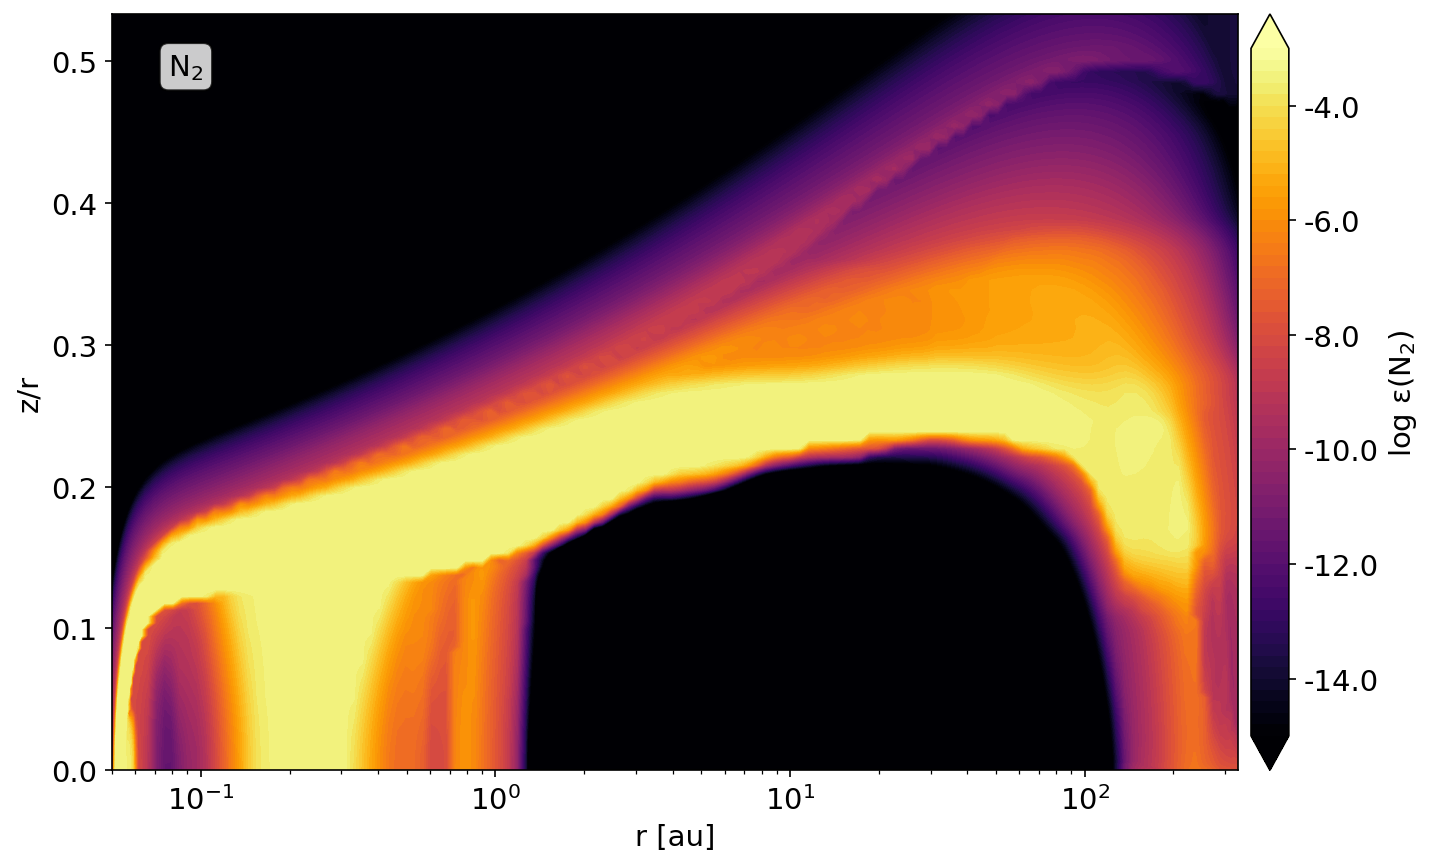

In [12]:
for i, model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)
    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")

    cbticks = [10, 30, 100, 300, 1000]
    fig=pp.plot_abuncont(model,"N2",zlim=[1.e-15, 1.e-3],extend="both",contour=False, cmap='inferno')

for i, ax in enumerate(fig.get_axes()):
    if i>=1:
        break
    ax.text(0.05, 0.95, r'N$_2$', transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig('Figures/AbundanceN2.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont_grid ...
[1e-15, 0.001]


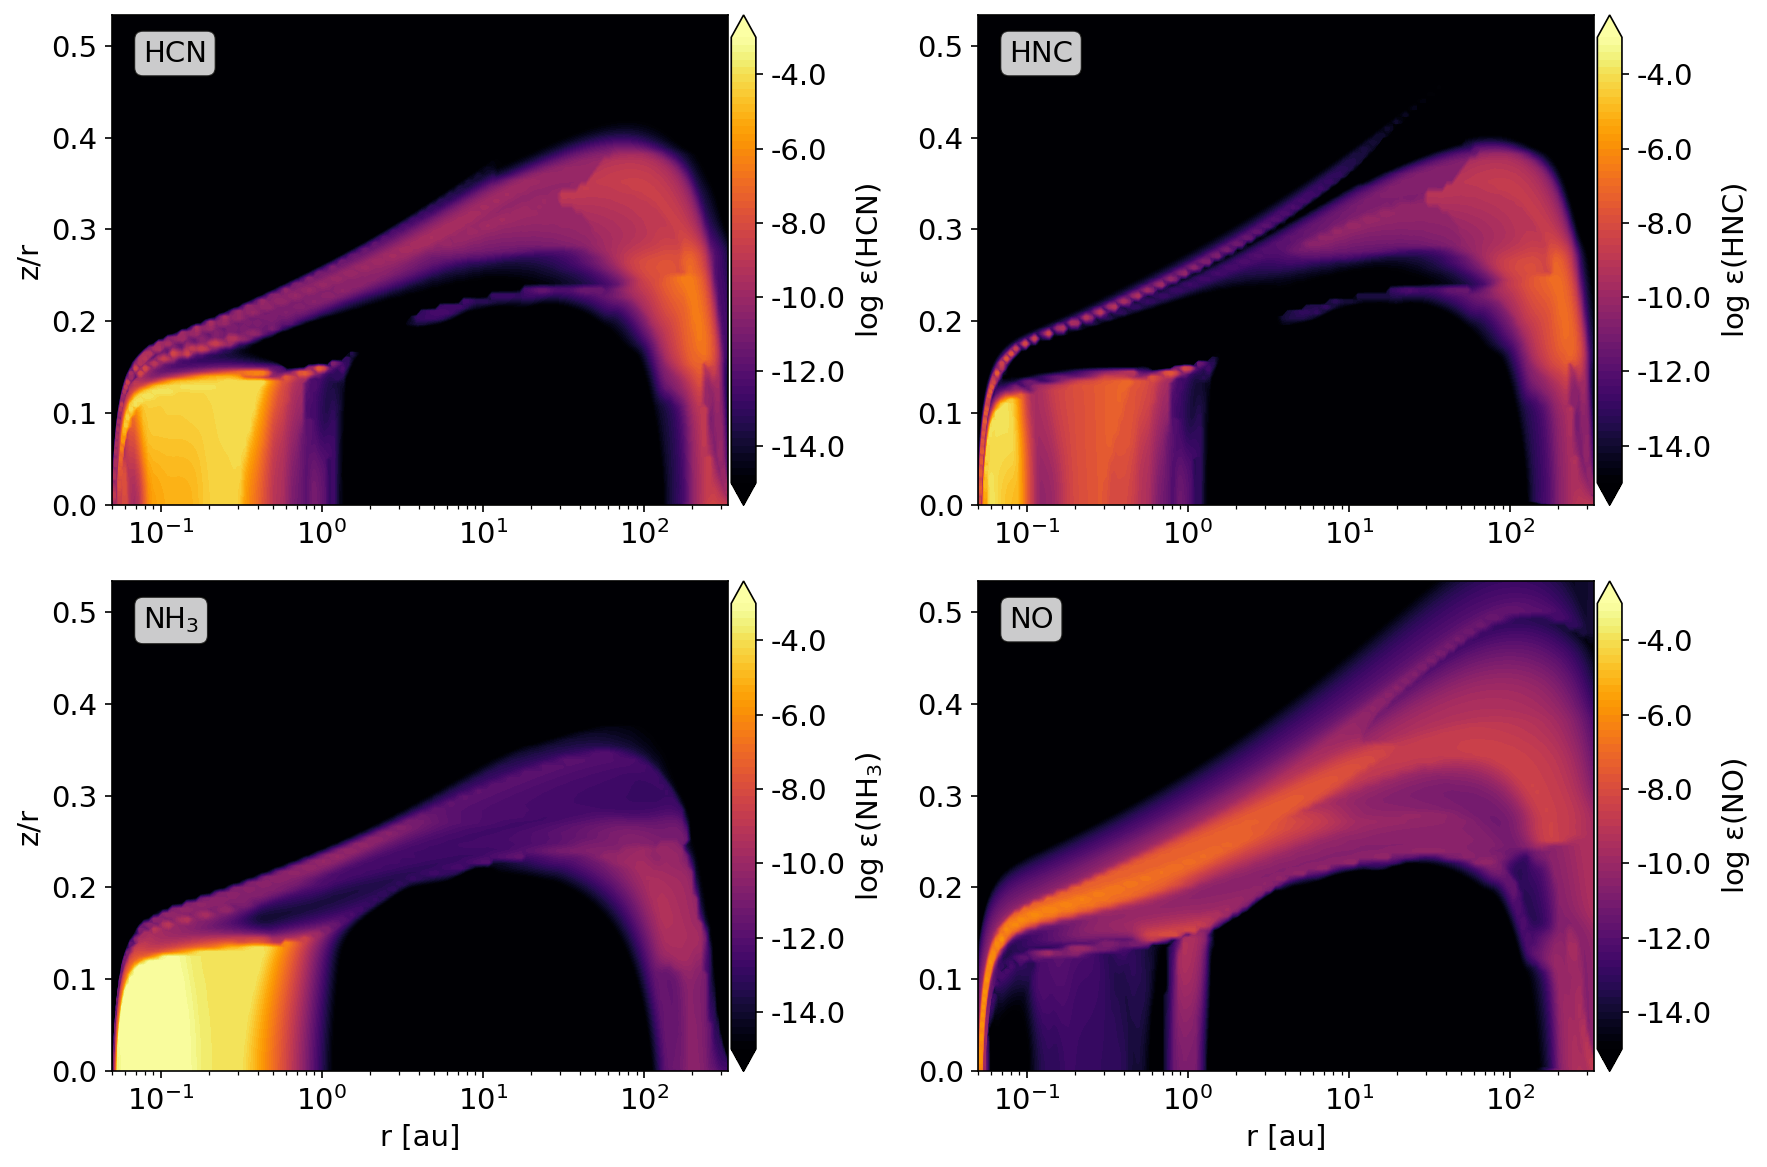

In [13]:
for i, model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)

    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    fig = pp.plot_abuncont_grid(model,
                              ["HCN", "HNC", "NH3", "NO"], nrows=2, ncols=2,
                              zlim=[1.e-15, 1.e-3], extend="both", contour=False, cmap='inferno')

    # _ =pp.plot_abuncont_grid(model,
    #                       ["HCN#","NH3#","NO#","H2O#"],nrows=2, ncols=2,
    #                       zlim=[1.e-8,1.e-3],extend="both",contour=False, cmap='inferno')
fig.set_size_inches(12, 8)
species = ["HCN","HNC" ,r"NH$_3$", "NO"]
for i, ax in enumerate(fig.get_axes()):
    if i>=4:
        break
    ax.text(0.05, 0.95, species[i], transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    if i in [0,1]:
        ax.set_xlabel('')
    if i in [3,1]:
        ax.set_ylabel('')
plt.tight_layout()
plt.savefig('Figures/Abundance2.pdf', bbox_inches='tight')
plt.show()

In [14]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

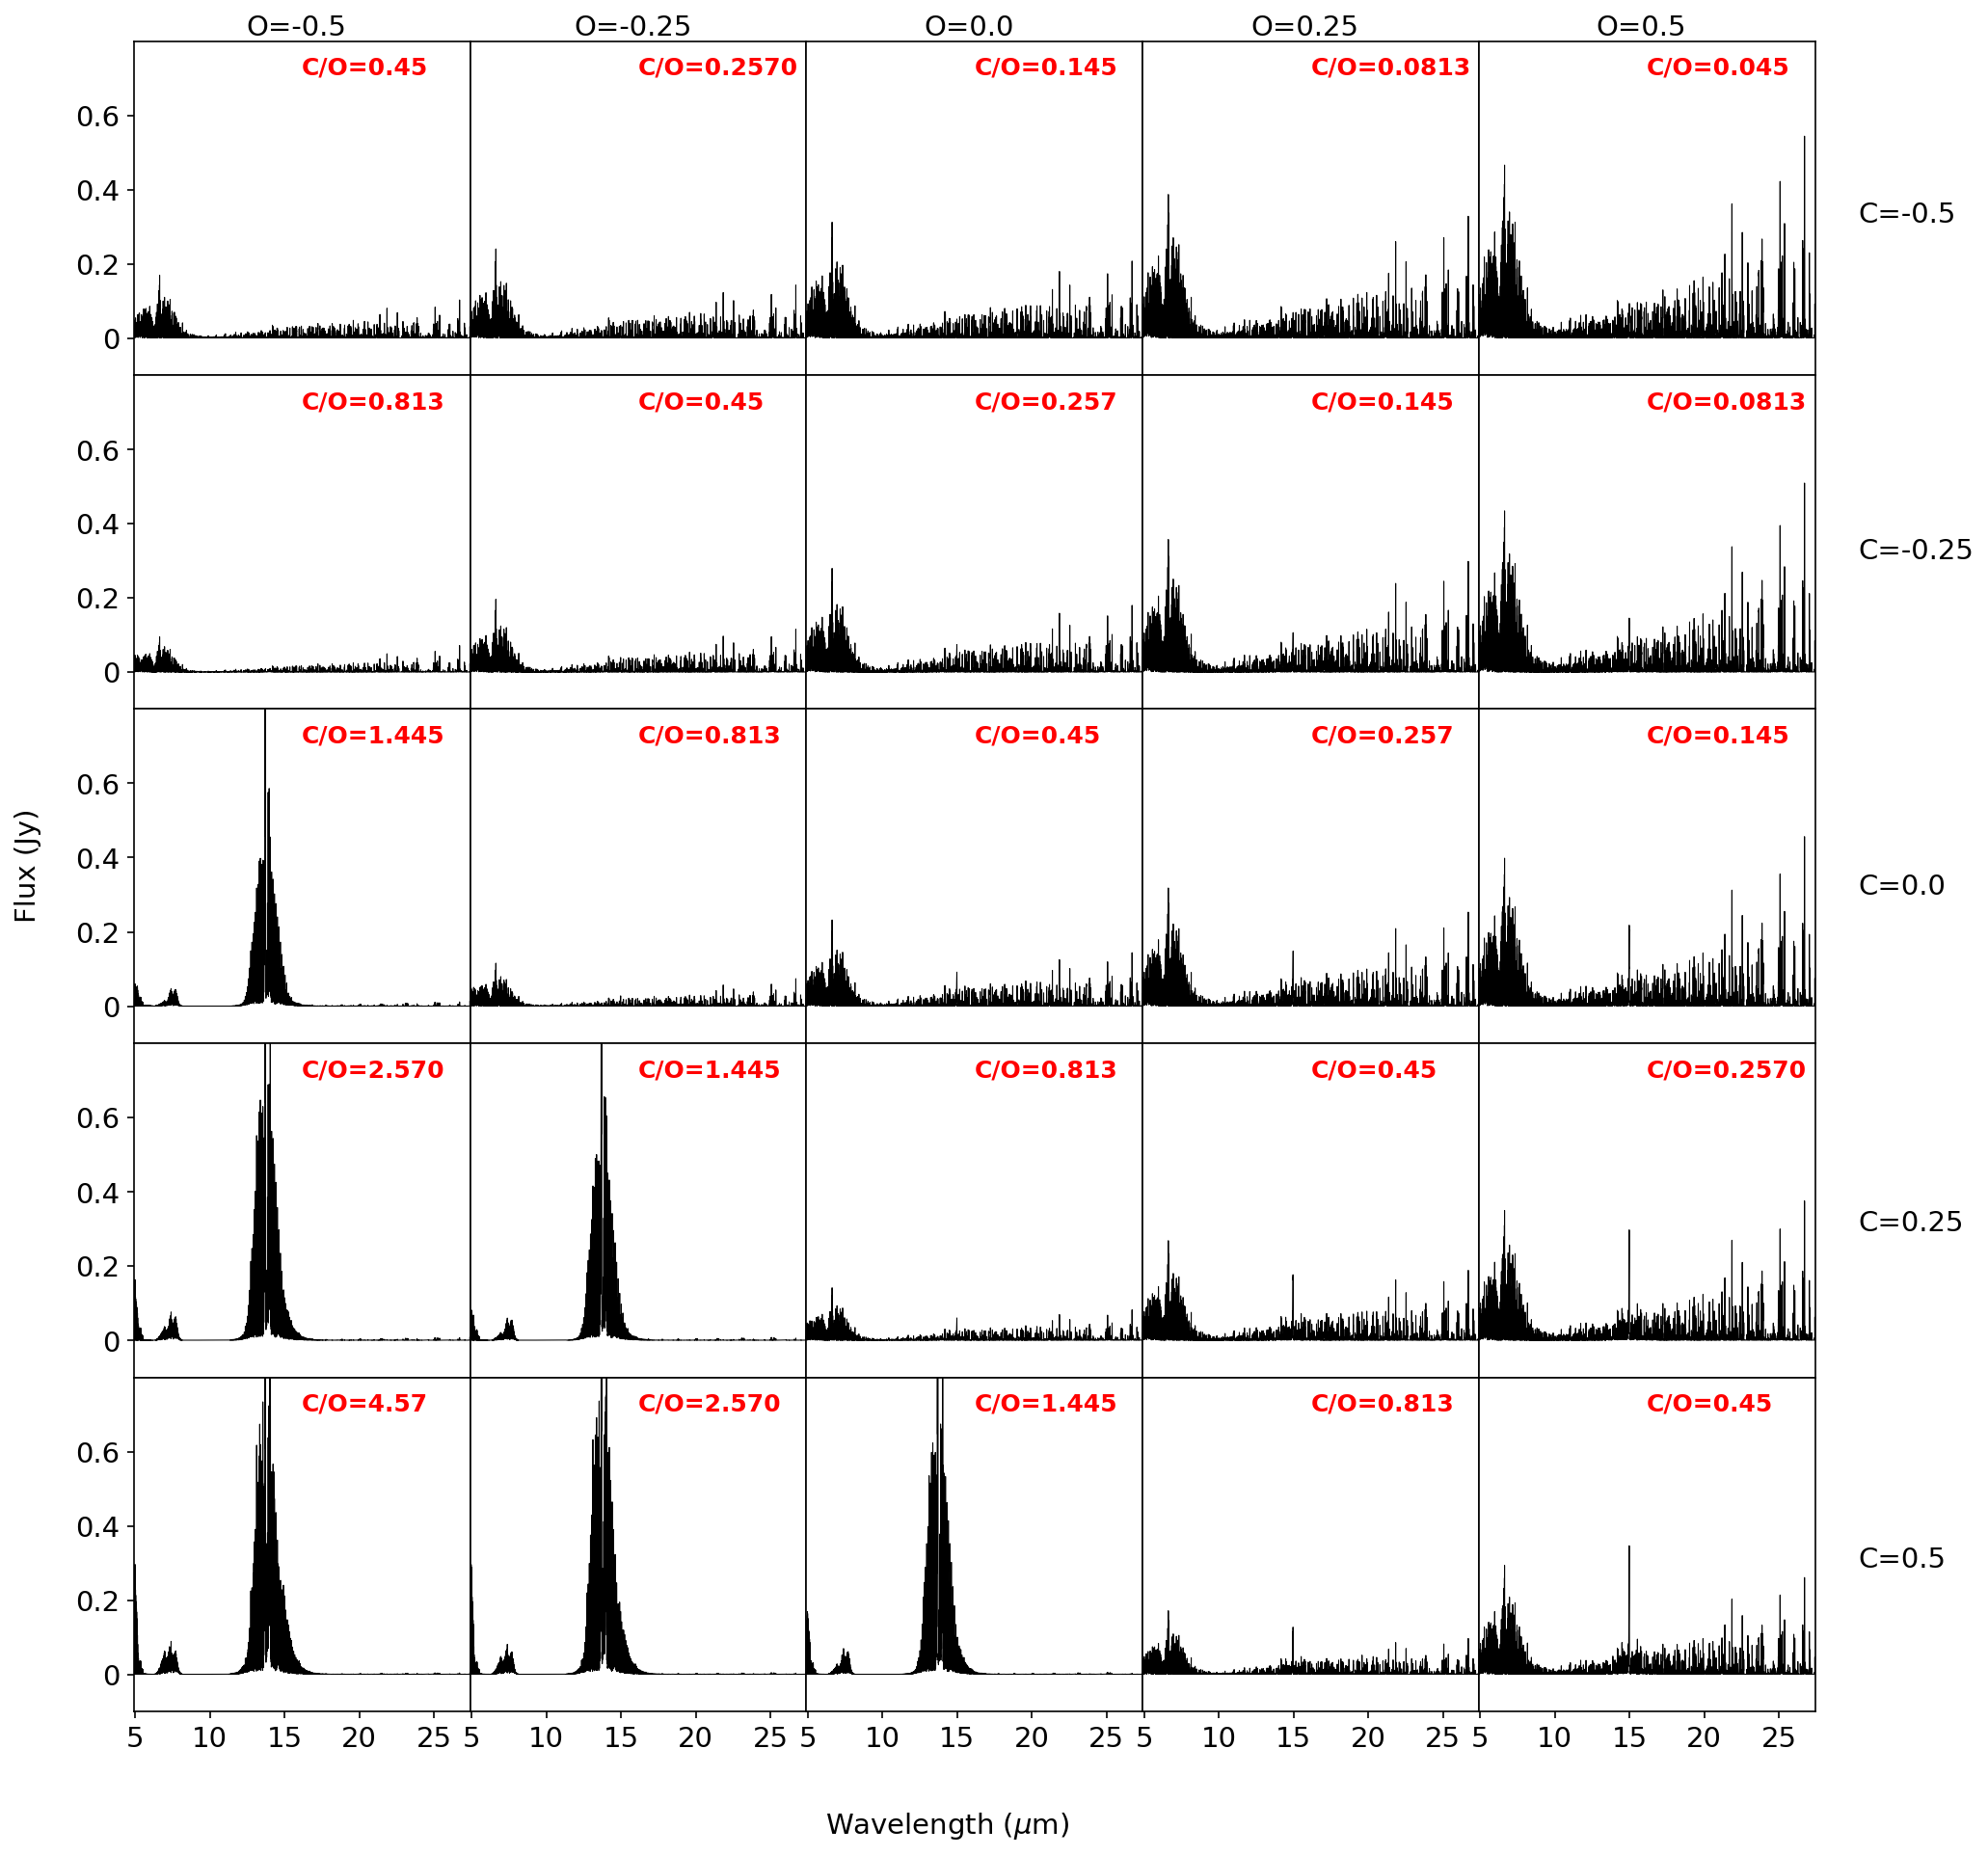

In [15]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.9, 27.4]
yrange=[-0.1,0.8]
num_xticks = 6
num_yticks = 5
xticks = [5, 10, 15, 20, 25, 30]
yticks = [0, 0.2, 0.4, 0.6, 0.8]
for i in range(25):
    n_row, n_col = divmod(i, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    model = df['Model Name'][i]
    FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
    FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
    # for index, specie in enumerate(species):
    #     specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    #     specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    #     new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    #     if total_spec is None:
    #         total_spec = new_specie_flux
    #     else:
    #         total_spec += new_specie_flux
    #     axes[i].fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
    #                     color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(FLiTs_wl, FLiTs_flux, c='black', lw=.5, label='FLiTs', zorder=20, rasterized=True)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.5, yrange[0] + (yrange[1] - yrange[0]) * 0.9,f'C/O={df.loc[df['Model Name'] == model, 'CO Value'].values[0]}', fontsize=12, color='red',weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        # axes[i].set_ylabel("Flux (Jy)", fontsize=14)
        axes[i].set_yticks(yticks[:-1])
        axes[i].set_yticklabels(yticks[:-1], fontsize=14)
    else:
        axes[i].tick_params(labelleft=False, left=False)
    if n_row == 4:
        # axes[i].set_xlabel(r"Wavelength ($\mu$m)", fontsize=14)
        axes[i].set_xticks(xticks[:-1])
        axes[i].set_xticklabels(xticks[:-1], fontsize=14)
    else:
        axes[i].tick_params(labelbottom=False, bottom=False)
# Convert to 2D array for easier indexing
axes_grid = axes.reshape(5, 5)

# Label top (columns)
for i in range(5):
    fig.text(0.2 + i * 0.155, 0.88, f'O={.25*i-0.5}', ha='center', va='bottom', fontsize=14)

# Add right row labels
for i in range(5):
    fig.text(0.92, 0.8 - i * 0.155, f'C={.25*i-0.5}', va='center', ha='left', fontsize=14)
fig.supxlabel(r'Wavelength ($\mu$m)', fontsize=14, y=0.05)
fig.supylabel('Flux (Jy)', fontsize=14, x=0.07)
plt.savefig('Figures/All_spectra.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
data = []
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)

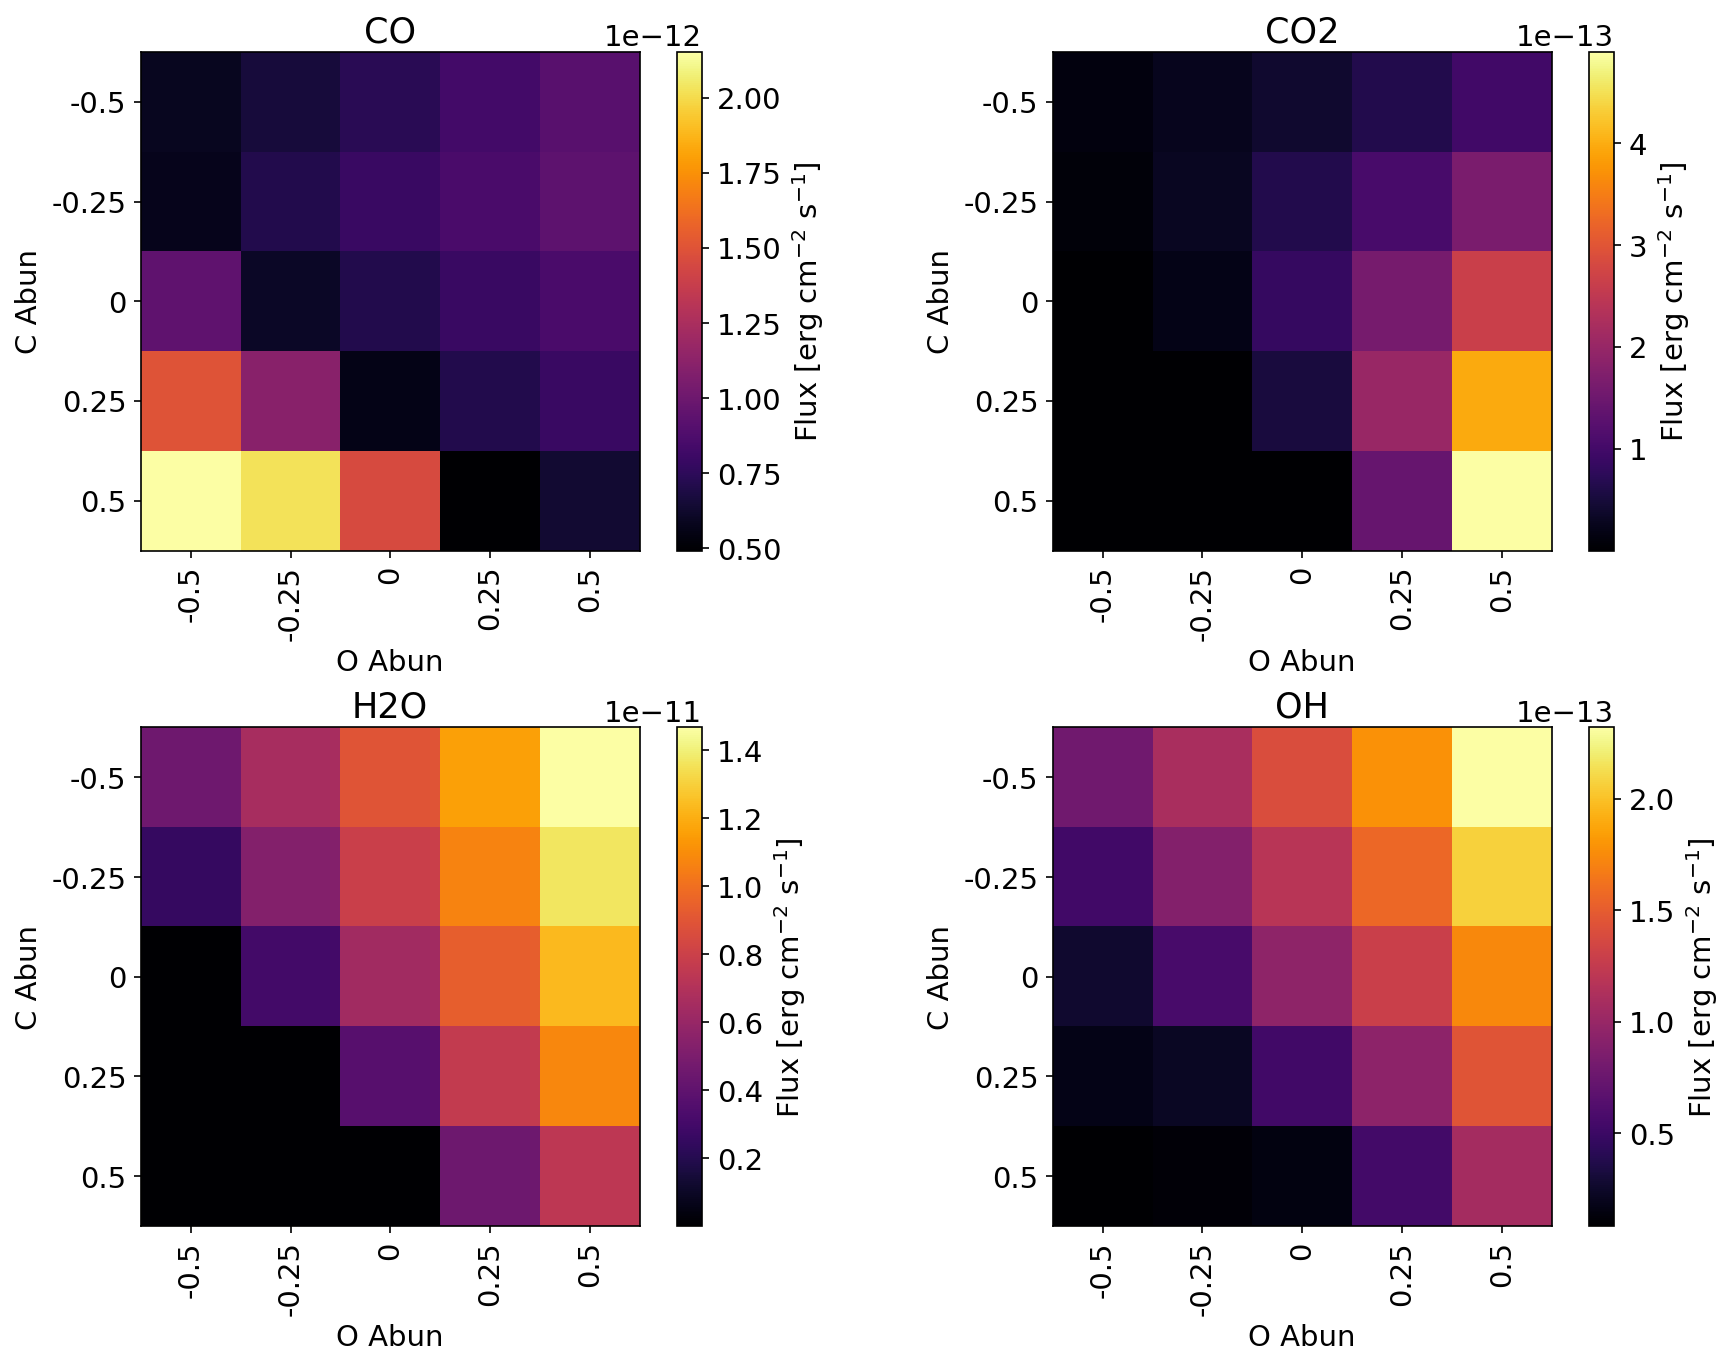

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)
axes = axes.flatten()

for i, specie in enumerate(['CO', 'CO2', 'H2O', 'OH']):
    im = axes[i].imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='inferno')
    axes[i].set_title(specie, pad=5)
    axes[i].set_xticks(np.arange(5))
    axes[i].set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    axes[i].set_yticks(np.arange(5))
    axes[i].set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5])
    axes[i].set_xlabel('O Abun')
    axes[i].set_ylabel('C Abun')

    # Use fig.colorbar without inset_axes
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.04, pad=-0.05, label='Flux [erg cm$^{-2}$ s$^{-1}$]')

fig.savefig('Figures/Heatmaps1.pdf')
plt.show()

# [erg cm$^{-2}$ s$^{-1}$]

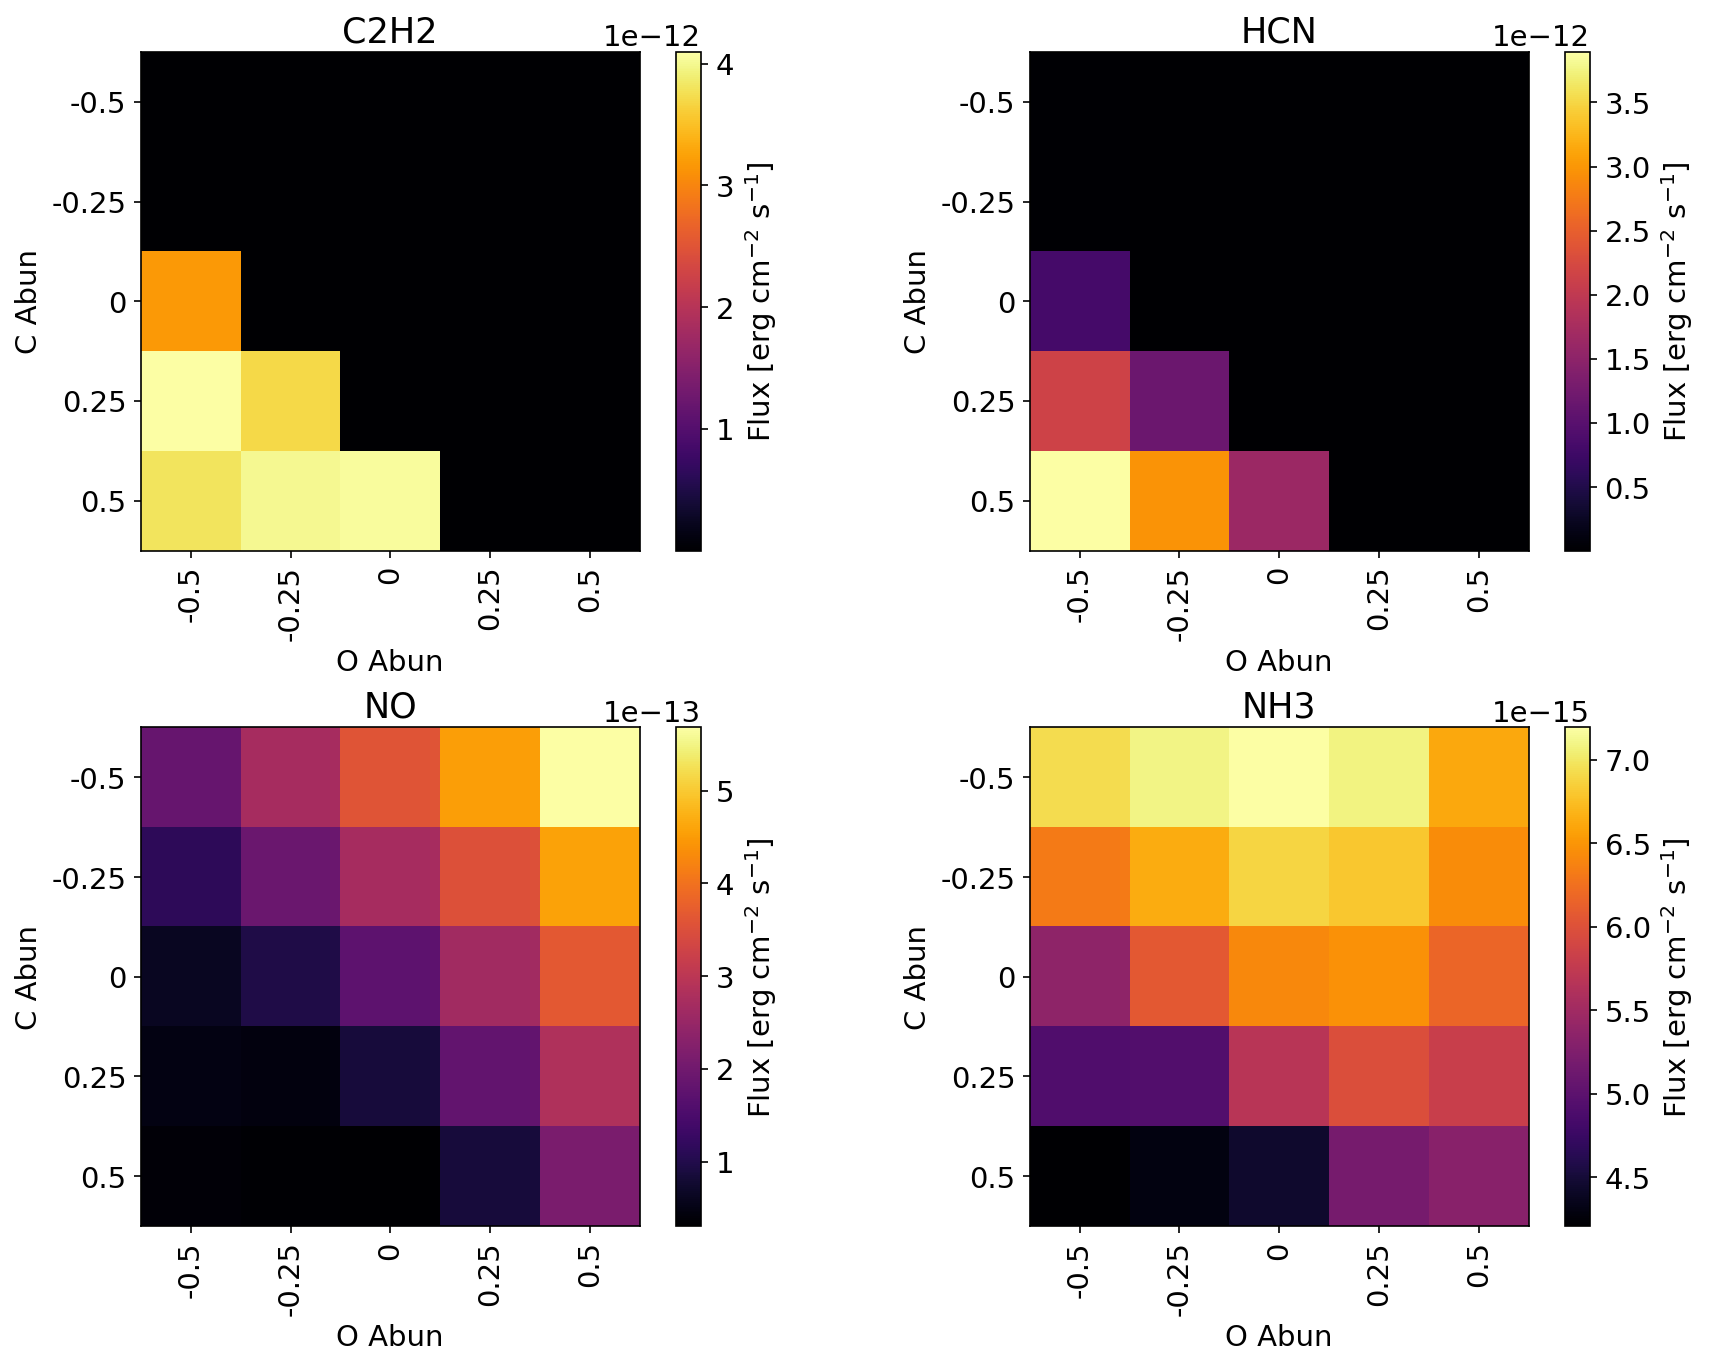

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)
axes = axes.flatten()

for i, specie in enumerate(['C2H2', 'HCN', 'NO', 'NH3']):
    im = axes[i].imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='inferno')
    axes[i].set_title(specie, pad=5)
    axes[i].set_xticks(np.arange(5))
    axes[i].set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    axes[i].set_yticks(np.arange(5))
    axes[i].set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5])
    axes[i].set_xlabel('O Abun')
    axes[i].set_ylabel('C Abun')

    # Use fig.colorbar without inset_axes
    fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.04, pad=-0.05, label='Flux [erg cm$^{-2}$ s$^{-1}$]')
fig.savefig('Figures/Heatmaps2.pdf')
plt.show()

# [erg cm$^{-2}$ s$^{-1}$]

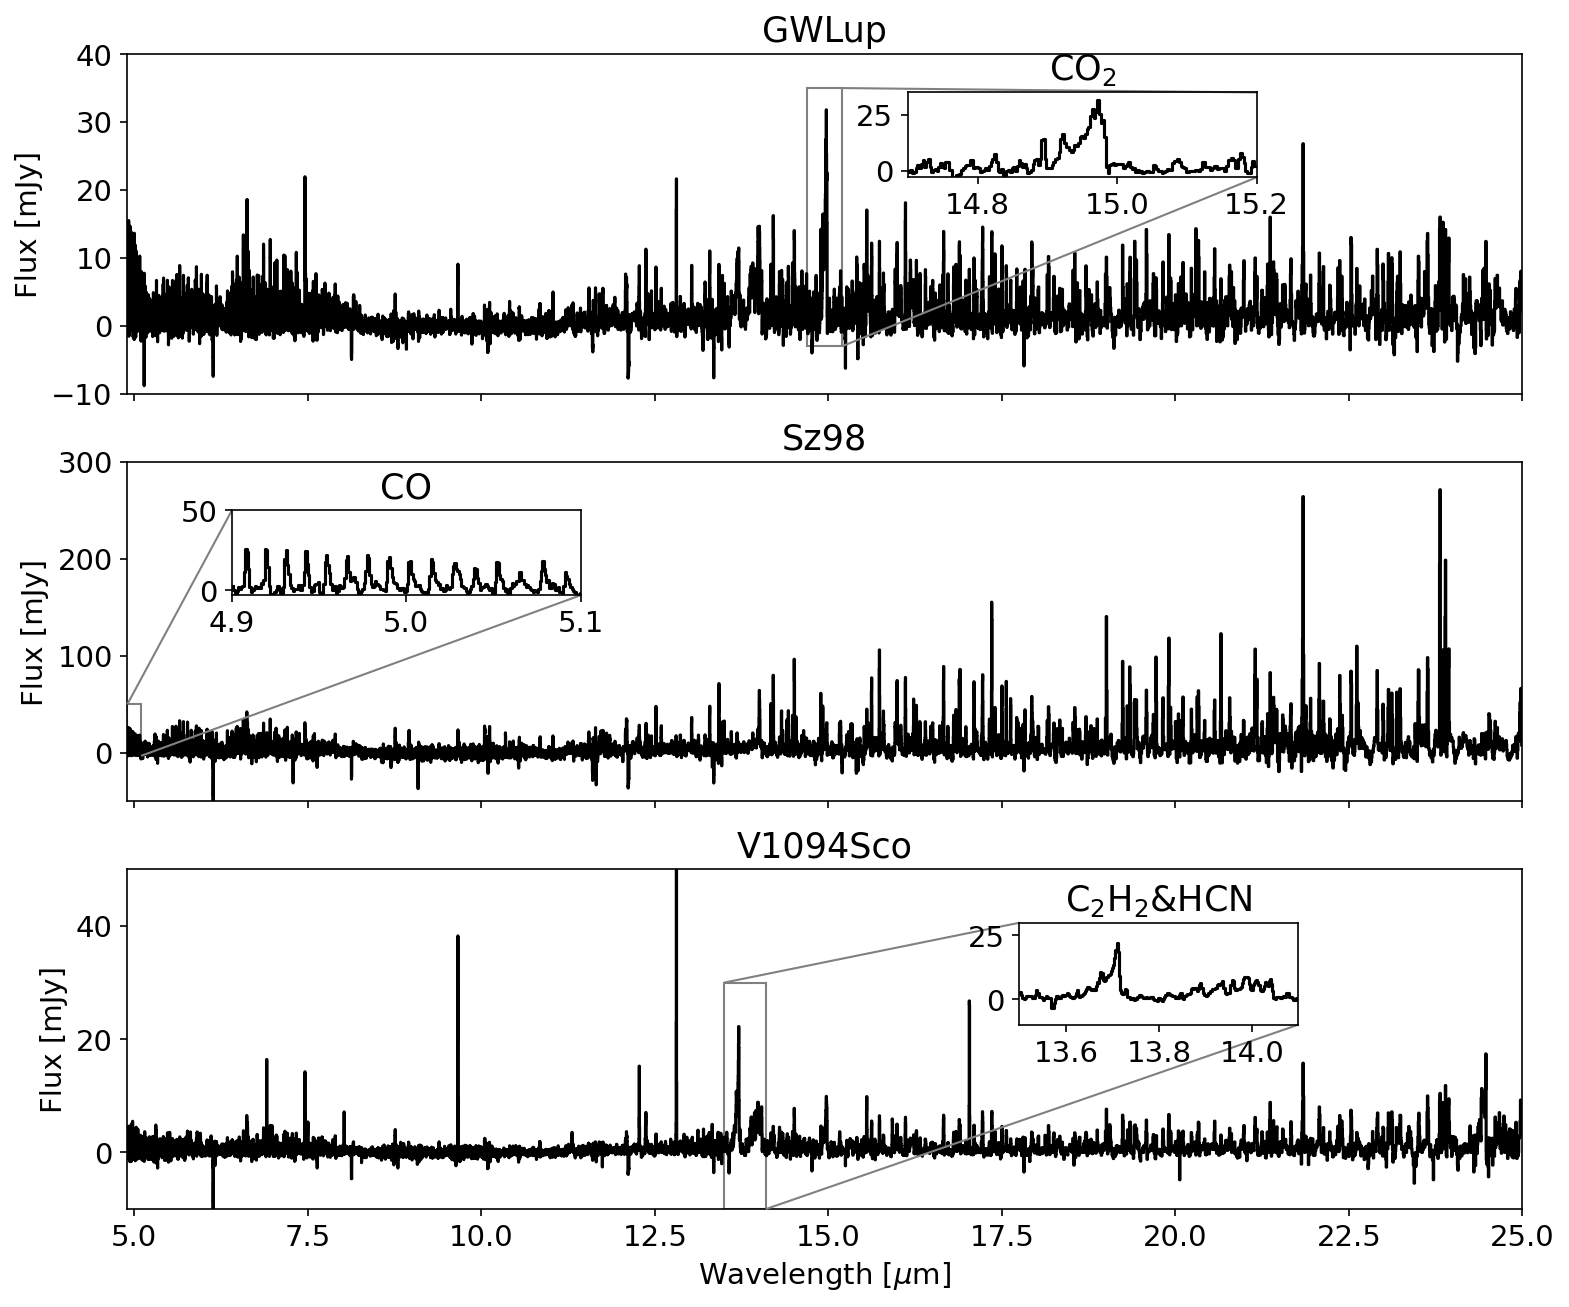

In [152]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

ylims = [(-10, 40), (-50, 300), (-10, 50)]
fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux_cont_sub = data['CSFlux']


    clip_min, clip_max = 4.9, 25

    clip_cnd = (wavelength >= clip_min) & (wavelength <= clip_max)
    axs[i].step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, color='black')
    axs[i].set_ylabel('Flux [mJy]')
    axs[i].set_xlim(clip_min, clip_max)
    axs[i].set_title(Source)
    axs[i].set_ylim(ylims[i])
    if i == 0 :
        axins = inset_axes(axs[i], width="25%", height="25%", bbox_to_anchor=(-0.18, -0.07, 1, 1),  # left, bottom, width, height (all relative to ax)
    bbox_transform=axs[i].transAxes,
    loc='upper right')
        axins.step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, c='black')
        axins.set_xlim(14.7, 15.2)
        axins.set_ylim(-3, 35)
        axins.set_title(r'CO$_2$')

        # Connect the inset with the main plot
        mark_inset(axs[i], axins, loc1=1, loc2=4, fc="none", ec="0.5")
    #     axins = inset_axes(axs[i], width="25%", height="25%", bbox_to_anchor=(-0.2, -0.09, 1, 1),  # left, bottom, width, height (all relative to ax)
    # bbox_transform=axs[i].transAxes,
    # loc='upper center')
    #     axins.step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, c='black')
    #     axins.set_xlim(6.5, 6.8)
    #     axins.set_ylim(-3, 35)
    #     axins.set_title(r'H$_2$O')
    #
    #     # Connect the inset with the main plot
    #     mark_inset(axs[i], axins, loc1=1, loc2=4, fc="none", ec="0.5")
    if i == 1 :
        axins = inset_axes(axs[i], width="25%", height="25%", bbox_to_anchor=(-0.3, -0.1, 1, 1),  # left, bottom, width, height (all relative to ax)
    bbox_transform=axs[i].transAxes,
    loc='upper center')
        axins.step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, c='black')
        axins.set_xlim(4.9, 5.1)
        axins.set_ylim(-3, 50)
        axins.set_title(r'CO')

        # Connect the inset with the main plot
        mark_inset(axs[i], axins, loc1=2, loc2=4, fc="none", ec="0.5")
    if i == 2:
        axins = inset_axes(axs[i], width="20%", height="30%", bbox_to_anchor=(-0.15, 0.5, 1, 1),  # left, bottom, width, height (all relative to ax)
    bbox_transform=axs[i].transAxes,
    loc='lower right')
        axins.step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, c='black')
        axins.set_xlim(13.5, 14.1)
        axins.set_ylim(-10, 30)
        axins.set_title(r'C$_2$H$_2$&HCN')
        # Connect the inset with the main plot
        mark_inset(axs[i], axins, loc1=2, loc2=4, fc="none", ec="0.5")
axs[-1].set_xlabel(r'Wavelength [$\mu$m]')
fig.savefig(f'Figures/Measurements.pdf', bbox_inches='tight')
plt.show()

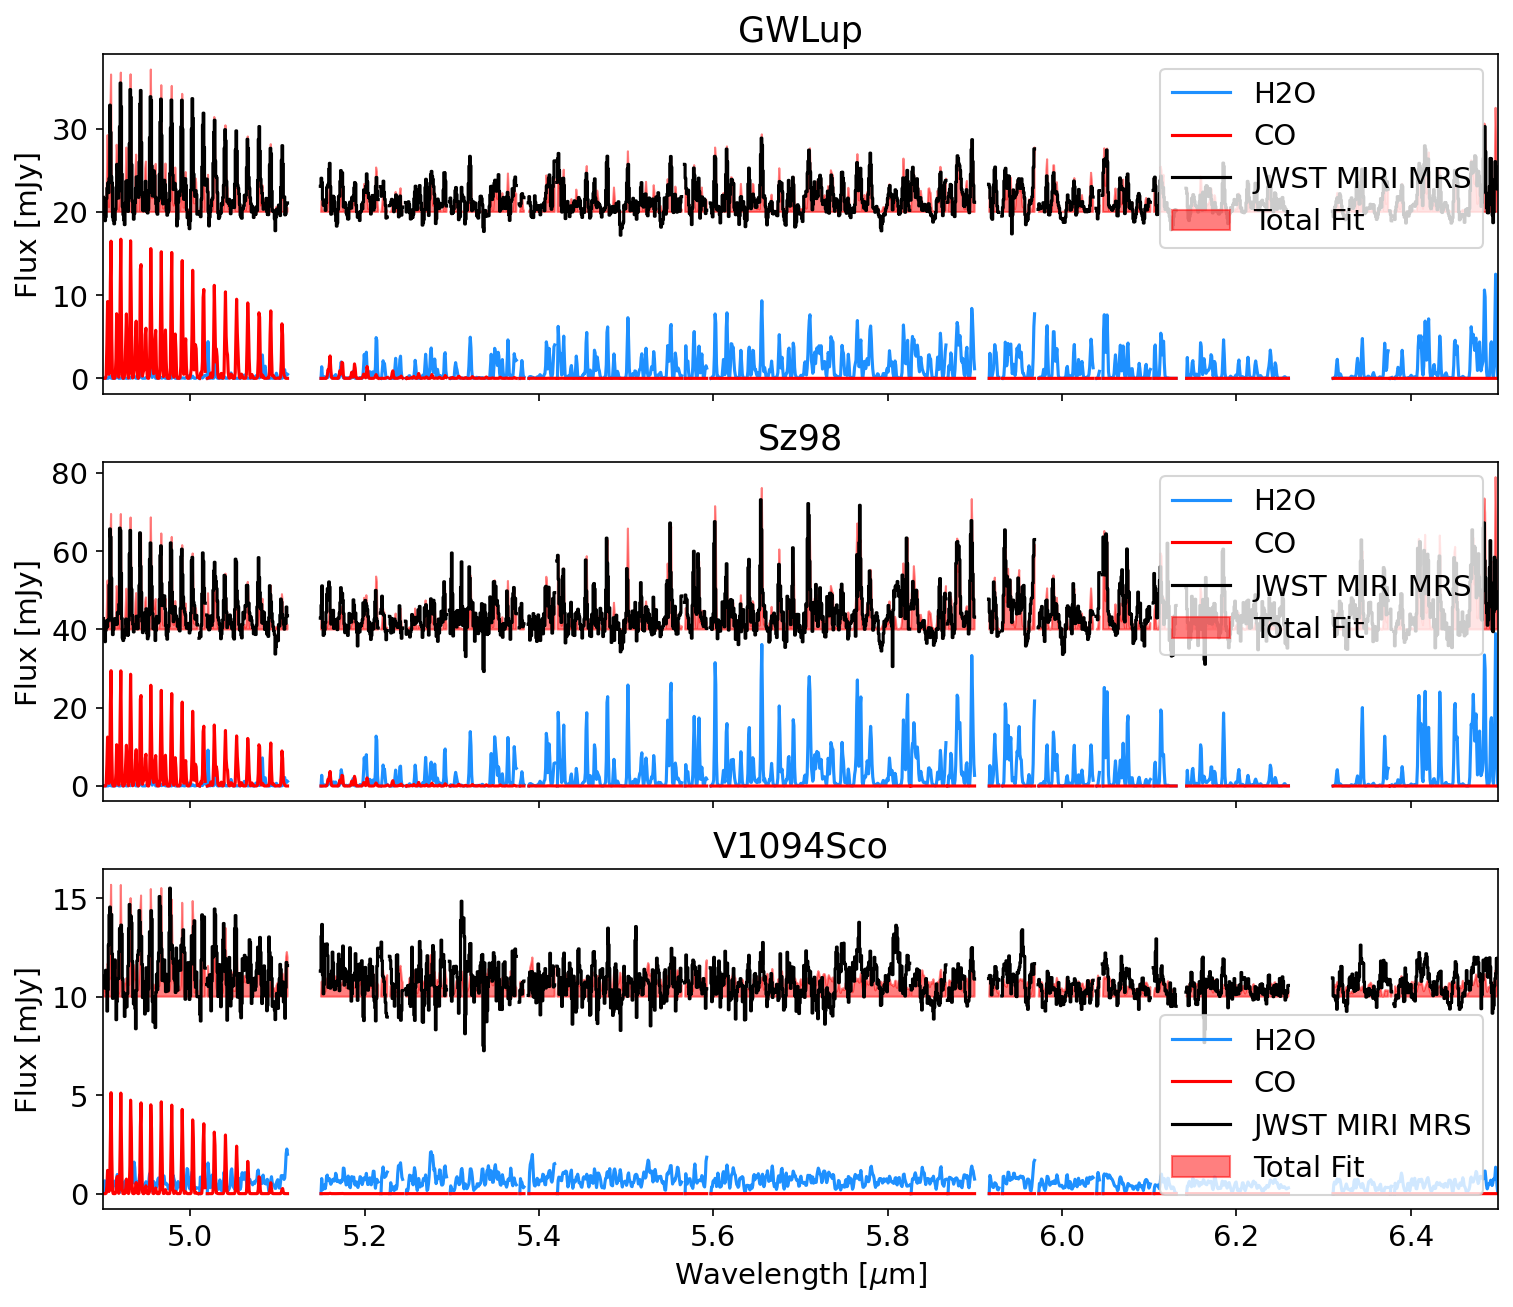

In [26]:
plt.show()
import math
from scipy.ndimage import gaussian_filter1d


def mask_regions(wavelength, flux, regions):
    new_flux = flux.copy()
    for region in regions:
        new_flux[np.logical_and(wavelength > region[0], wavelength < region[1])] = np.nan
    return new_flux


artefact_regions = [[5.0091, 5.01071], [5.018, 5.019], [5.112, 5.15],
                    [5.2157, 5.2184], [5.2267, 5.2290], [5.2441, 5.2471],
                    [5.2947, 5.2974], [5.3742, 5.3777], [5.3836, 5.3877],
                    [5.4181, 5.4210], [5.5644, 5.5674], [5.5925, 5.5966],
                    [5.8252, 5.8267], [5.8669, 5.8689], [5.9, 5.916], [5.9282, 5.9314],
                    [5.9691, 5.9728], [6.0357, 6.0394], [6.0430, 6.0462],
                    [6.1012, 6.1044], [6.1311, 6.1421], [6.26, 6.31], [6.3740, 6.3757],
                    [6.3783, 6.3810], [18.8055, 18.8145], [19.004, 19.012],
                    [21.974, 21.985], [25.69824, 25.71313]]
fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):

    # Load main spectrum data
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux_cont_sub = data['CSFlux']

    clip_min, clip_max = 4.9, 6.5  # micron

    # Mask artefact regions
    mask = np.ones_like(wavelength, dtype=bool)
    for start, end in artefact_regions:
        mask &= ~((wavelength >= start) & (wavelength <= end))

    clip_cnd = (wavelength >= clip_min) & (wavelength <= clip_max)
    total = np.zeros_like(flux_cont_sub[clip_cnd])

    for mol in ['H2O', 'CO']:
        file = f'{Source}4_9_6_3/{mol}_best_fit.p'
        data = pickle.load(open(file, 'rb'))
        o_w = data['o_w']
        m_f = np.nan_to_num(data['m_f'], nan=0)
        rdisk_sq = data['Rdisk_best'] ** 2
        axs[i].plot(o_w, mask_regions(o_w, 1000 * m_f * rdisk_sq, artefact_regions), c=colors[mol], label=mol)
        total += m_f * rdisk_sq

    # Add offset JWST spectrum and total fit
    offset = math.ceil(max(1000 * flux_cont_sub[clip_cnd]) / 10) * 10
    masked_flux = 1000 * mask_regions(wavelength[clip_cnd], flux_cont_sub[clip_cnd], artefact_regions) + offset
    axs[i].step(wavelength[clip_cnd], masked_flux, color='black', label='JWST MIRI MRS')

    masked_total = 1000 * mask_regions(wavelength[clip_cnd], total, artefact_regions) + offset
    axs[i].fill_between(wavelength[clip_cnd], offset, masked_total, color='r', alpha=0.5, label='Total Fit')

    # Labeling and styling
    # axs[i].set_xlabel(r'Wavelength [$\mu$m]')
    axs[i].set_ylabel('Flux [mJy]')
    axs[i].set_xlim(clip_min, clip_max)
    axs[i].set_title(Source)
    axs[i].legend()
axs[-1].set_xlabel(r'Wavelength [$\mu$m]')
# Save and show
fig.savefig(f'Figures/Fits.pdf', bbox_inches='tight')
plt.show()

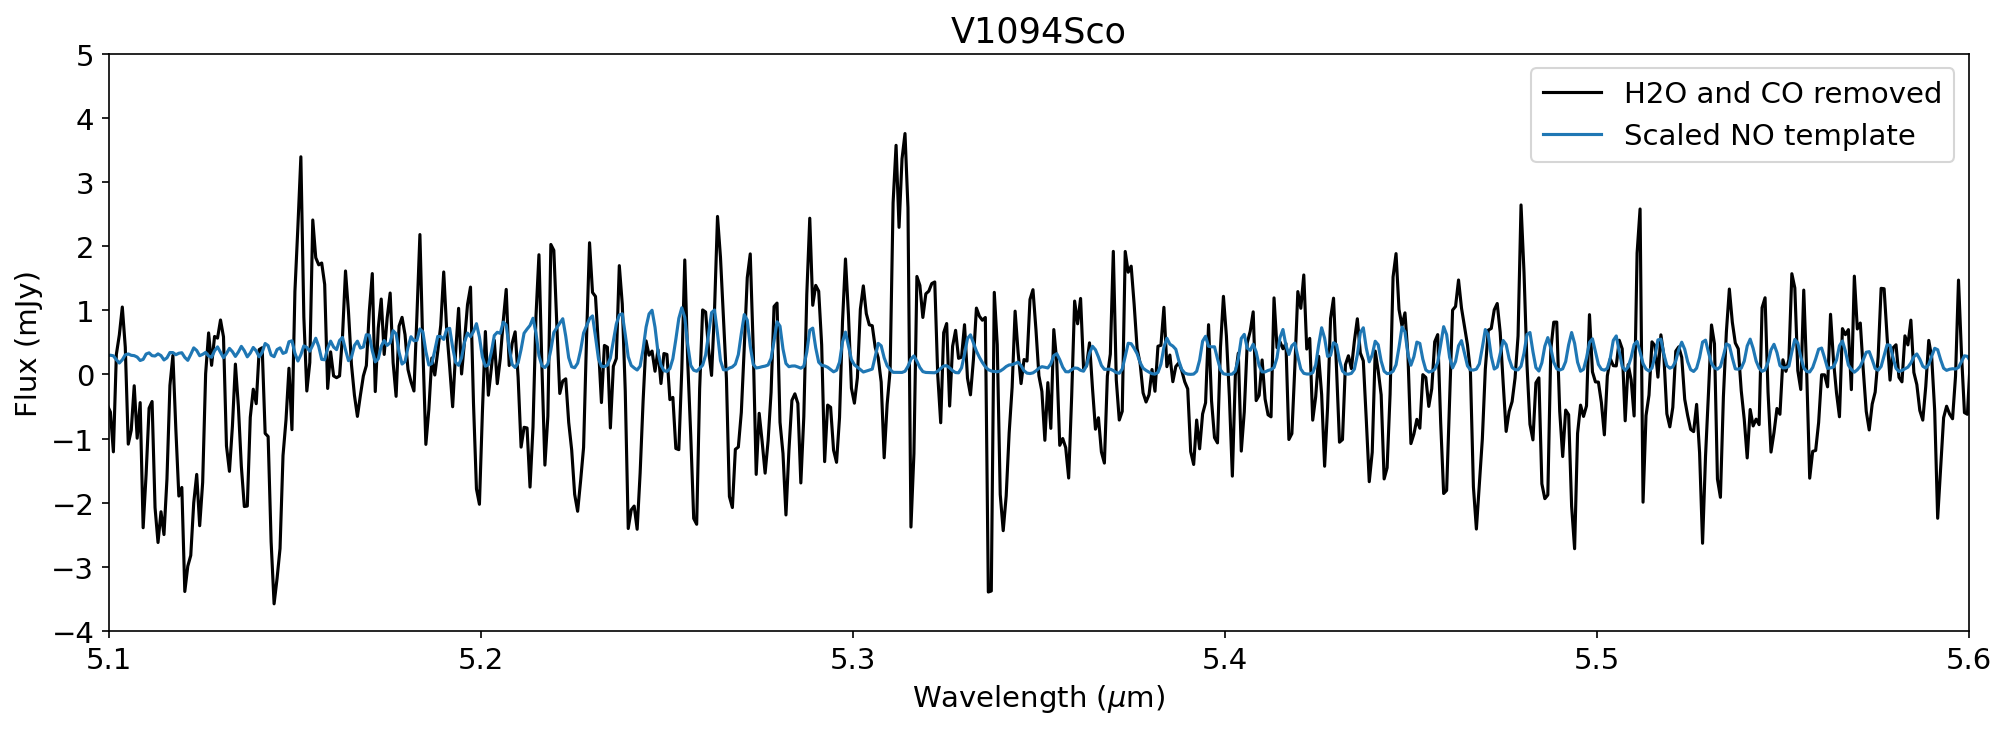

In [27]:
for Source in ['V1094Sco']:

    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux_cont_sub = data['CSFlux']

    clip_min, clip_max = 4.9, 6.5  # micron

    species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'OH']
    colors = {'atomic': 'tomato', 'C2H2': 'yellow', 'CH4': 'mediumorchid', 'CO': 'red', 'CO2': 'limegreen', 'H2O': 'dodgerblue',
          'HCN': 'orange', 'NH3': 'cyan', 'NO': 'gold', 'OH': 'magenta'}
    avg_flux = {}
    total_wl = wavelength
    for specie in species:
        total_flux = np.zeros_like(total_wl)
        for i,row in df.iterrows():
            specie_wl = row[f'FLiTs {specie} Wavelength']
            specie_flux = row[f'FLiTs {specie} Flux']
            specie_flux = np.interp(total_wl, specie_wl, specie_flux)
            total_flux += specie_flux
        total_flux /= 25
        avg_flux.update({specie:total_flux})
    mask = np.ones_like(wavelength, dtype=bool)
    for start, end in artefact_regions:
        mask &= ~((wavelength >= start) & (wavelength <= end))

    clip_cnd = ((wavelength >= clip_min) & (wavelength <= clip_max))
    total = flux_cont_sub[clip_cnd].copy()
    plt.figure(figsize=(16,5))
    for mol in ['H2O', 'CO']:
        file = f'{Source}4_9_6_3/{mol}_best_fit.p'
        data = pickle.load(open(file, 'rb'))
        o_w = data['o_w']
        # o_w = np.nan_to_num(o_w, nan=0)
        m_f = data['m_f']
        m_f = np.nan_to_num(m_f, nan=0)
        # plt.plot(o_w, mask_regions(o_w, 1000*m_f*data['Rdisk_best']**2, artefact_regions), label=mol)
        total-=m_f*data['Rdisk_best']**2
    # offset = math.ceil(max(1000*flux_cont_sub[clip_cnd])/10)*10
    # print(offset)
    # plt.step(wavelength[clip_cnd], 1000*mask_regions(wavelength[clip_cnd], flux_cont_sub[clip_cnd], artefact_regions)+offset, color='black', label='JSWT MIRI MRS')
    # plt.fill_between(wavelength[clip_cnd], offset, 1000*mask_regions(wavelength[clip_cnd], total, artefact_regions)+offset, color='r', alpha=0.5, label='Total Fit')
    # plt.xlabel(r'Wavelength [$\mu$m]')
    # plt.ylabel('Flux [mJy]')
    # plt.xlim(clip_min, clip_max)
    # plt.title(Source)
    # plt.legend()
    # plt.savefig(f'Figures/Fit_{Source}.pdf', bbox_inches='tight')
    # plt.show()
    # plt.figure(figsize=(16,7))
    plt.plot(wavelength[clip_cnd], total*1000, color='black', label='H2O and CO removed')
    plt.plot(wavelength[clip_cnd], avg_flux['NO'][clip_cnd]*100, label='Scaled NO template')
    plt.legend()
    plt.title(Source)
    plt.xlim(5.1, 5.6)
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel('Flux (mJy)')
    plt.ylim(-4, 5)
    plt.savefig(f'Figures/NO_Detect.pdf', dpi=300, bbox_inches='tight')
    plt.show()

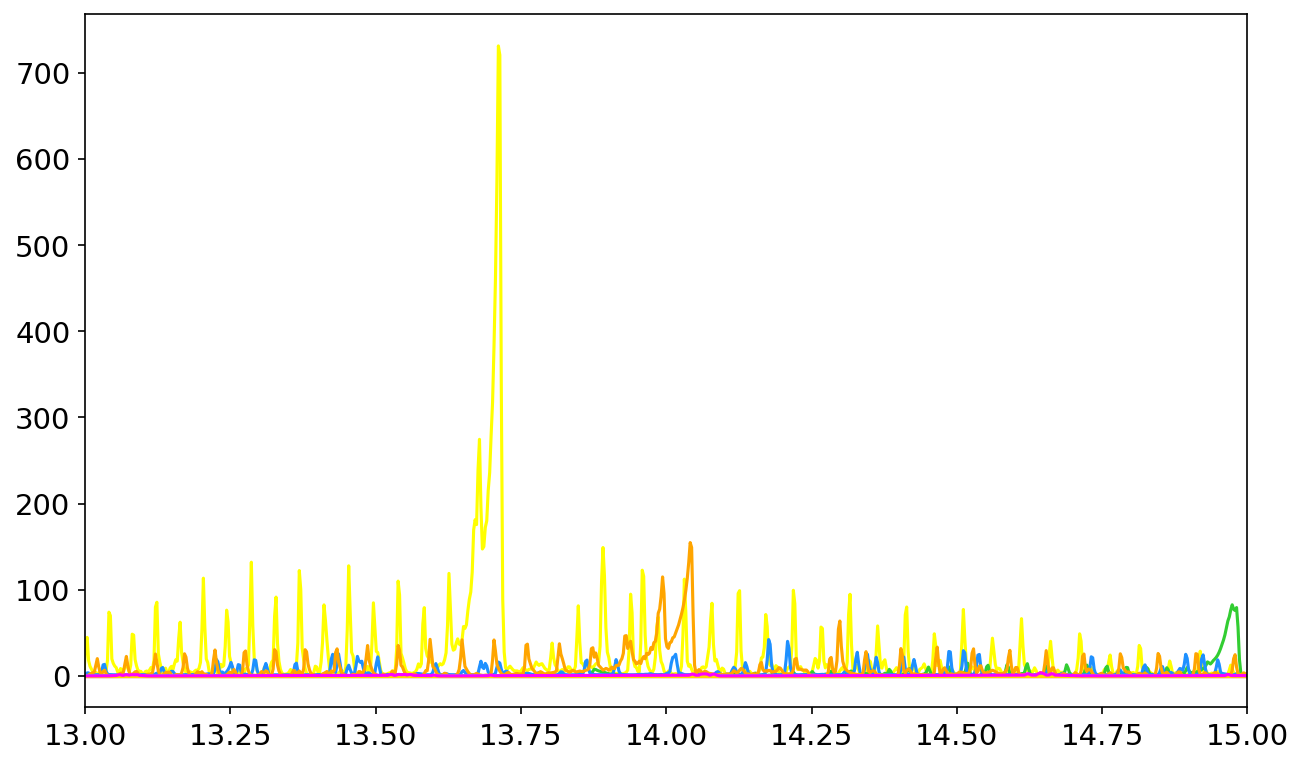

In [41]:
for specie in species:
    plt.plot(total_wl, avg_flux[specie]*1000, label=specie, c=colors[specie])
plt.xlim(13, 15)
plt.show()

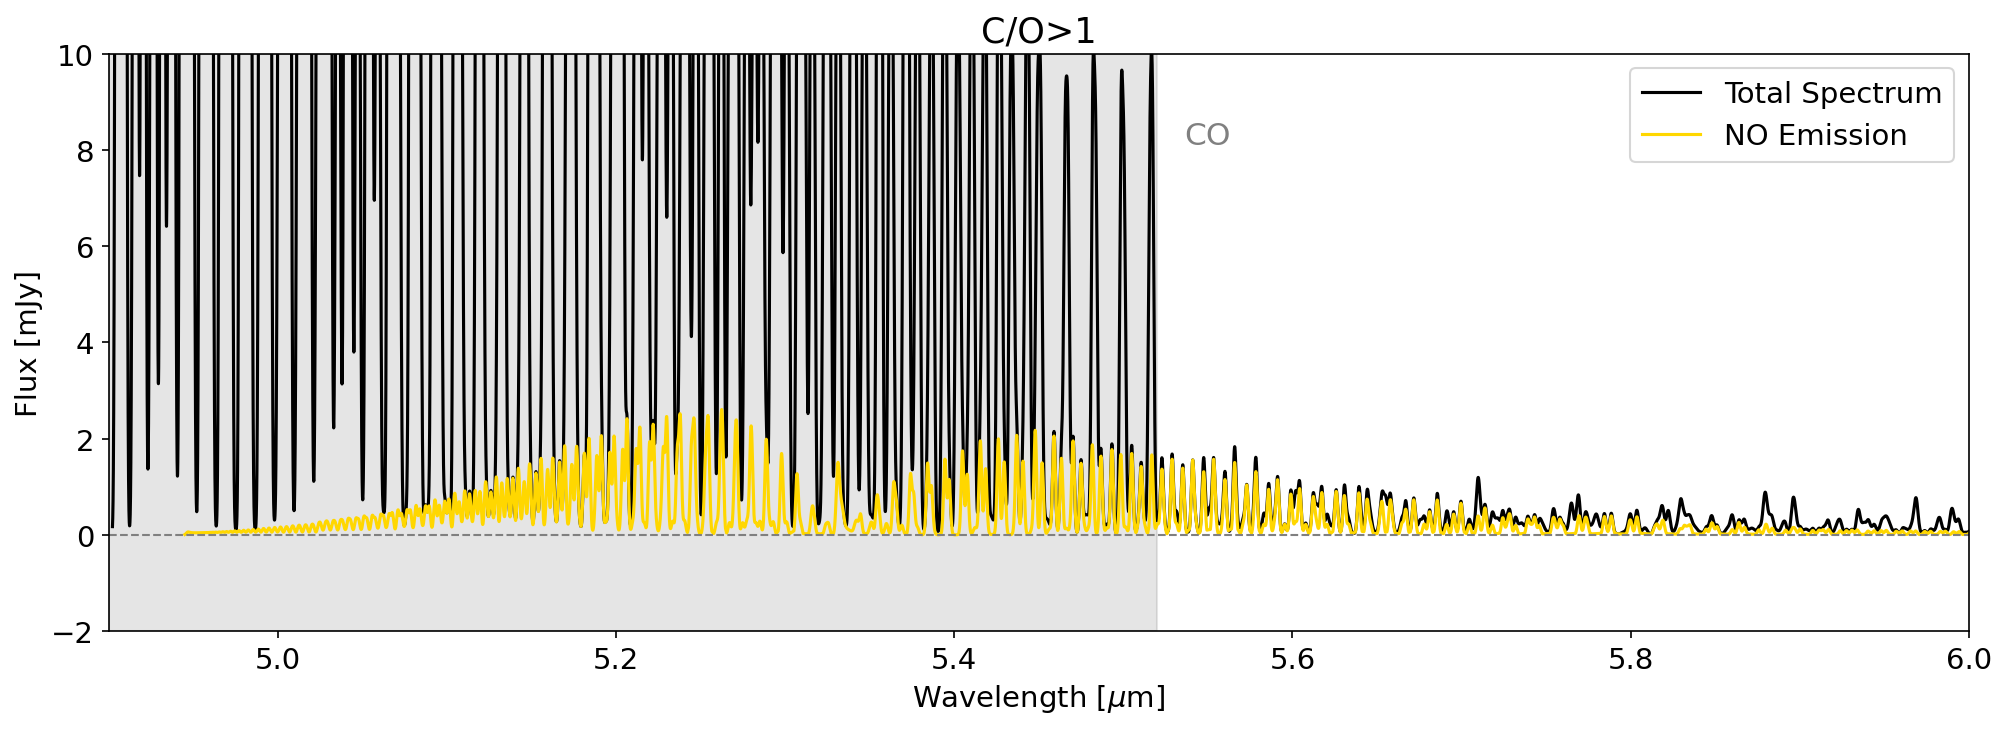

In [132]:
species = ['NO']
clip_min, clip_max = 4.9, 6
plt.figure(figsize=(16, 5))
for target in species:
    for i, row in df.iterrows():
        if i != 16:
            continue
        # plt.figure(figsize=(16, 5))

        wavelength = row['FLiTs Wavelength'].copy()
        flux_cont_sub = row['FLiTs Flux'].copy()
        continuum = row['FLiTs Flux Continuum'].copy()

        NH3_wl = row['FLiTs NH3 Wavelength'].copy()
        NH3_flux = row['FLiTs NH3 Flux'].copy()
        NH3_flux = np.interp(wavelength, NH3_wl, NH3_flux)

        flux_cont_sub += NH3_flux
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=np.inf) - continuum

        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']

        plt.plot(wavelength, flux_cont_sub*1000, c='black', label='Total Spectrum')
        plt.plot(real_wl, real_flux*1000, c=colors[target], label=f'{target} Emission')

        plt.title(f'C/O>1')
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.xlim(clip_min, clip_max)
        plt.ylim(-2, 10)
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux [mJy]')
        plt.legend(loc='upper right')
        plt.axvspan(4.9, 5.52, color='grey', alpha=0.2)
        plt.text(5.55, 8, 'CO', ha='center', va='bottom', fontsize=15, color='grey')
        # plt.savefig('Figures/NO_region.pdf', bbox_inches='tight')

plt.show()

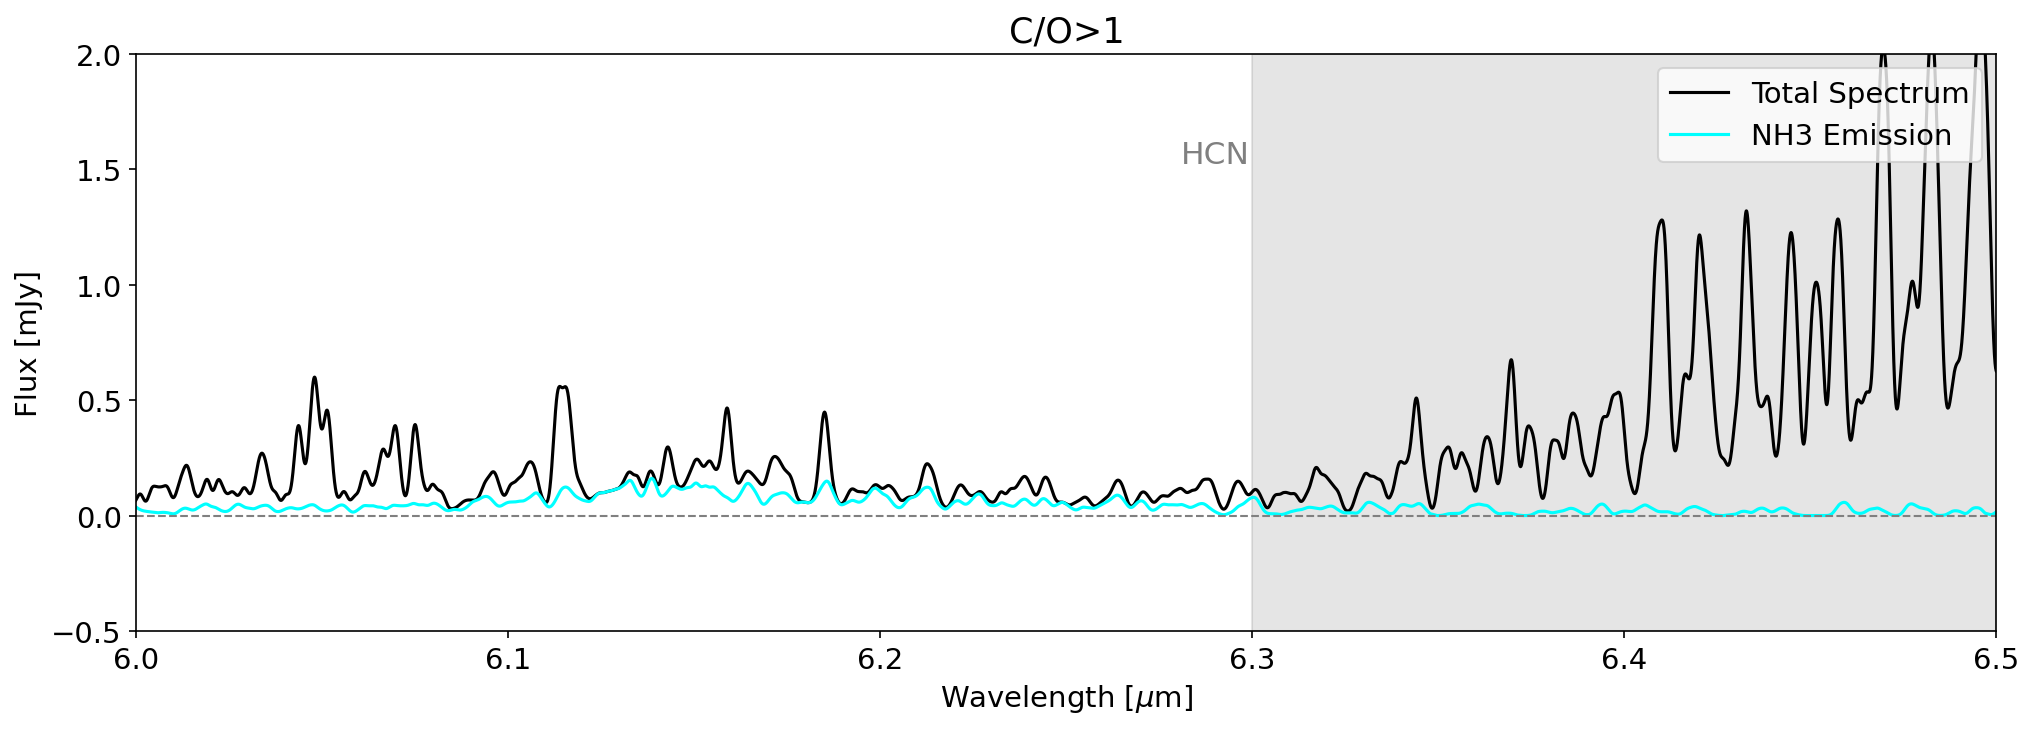

In [129]:
species = ['NH3']
clip_min, clip_max = 6, 6.5
plt.figure(figsize=(16, 5))
for target in species:
    for i, row in df.iterrows():
        if i != 16:
            continue
        # plt.figure(figsize=(16, 5))

        wavelength = row['FLiTs Wavelength'].copy()
        flux_cont_sub = row['FLiTs Flux'].copy()
        continuum = row['FLiTs Flux Continuum'].copy()

        NH3_wl = row['FLiTs NH3 Wavelength'].copy()
        NH3_flux = row['FLiTs NH3 Flux'].copy()
        NH3_flux = np.interp(wavelength, NH3_wl, NH3_flux)

        flux_cont_sub += NH3_flux
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=np.inf) - continuum

        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']

        plt.plot(wavelength, flux_cont_sub*1000, c='black', label='Total Spectrum')
        plt.plot(real_wl, real_flux*1000, c=colors[target], label=f'{target} Emission')

        plt.title(f'C/O>1')
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.xlim(clip_min, clip_max)
        plt.ylim(-0.5, 2)
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux [mJy]')
        plt.legend(loc='upper right')
        plt.axvspan(6.3, 6.5, color='grey', alpha=0.2)
        plt.text(6.29, 1.5, 'HCN', ha='center', va='bottom', fontsize=15, color='grey')
        plt.savefig('Figures/NH3_region1.pdf', bbox_inches='tight')
plt.show()

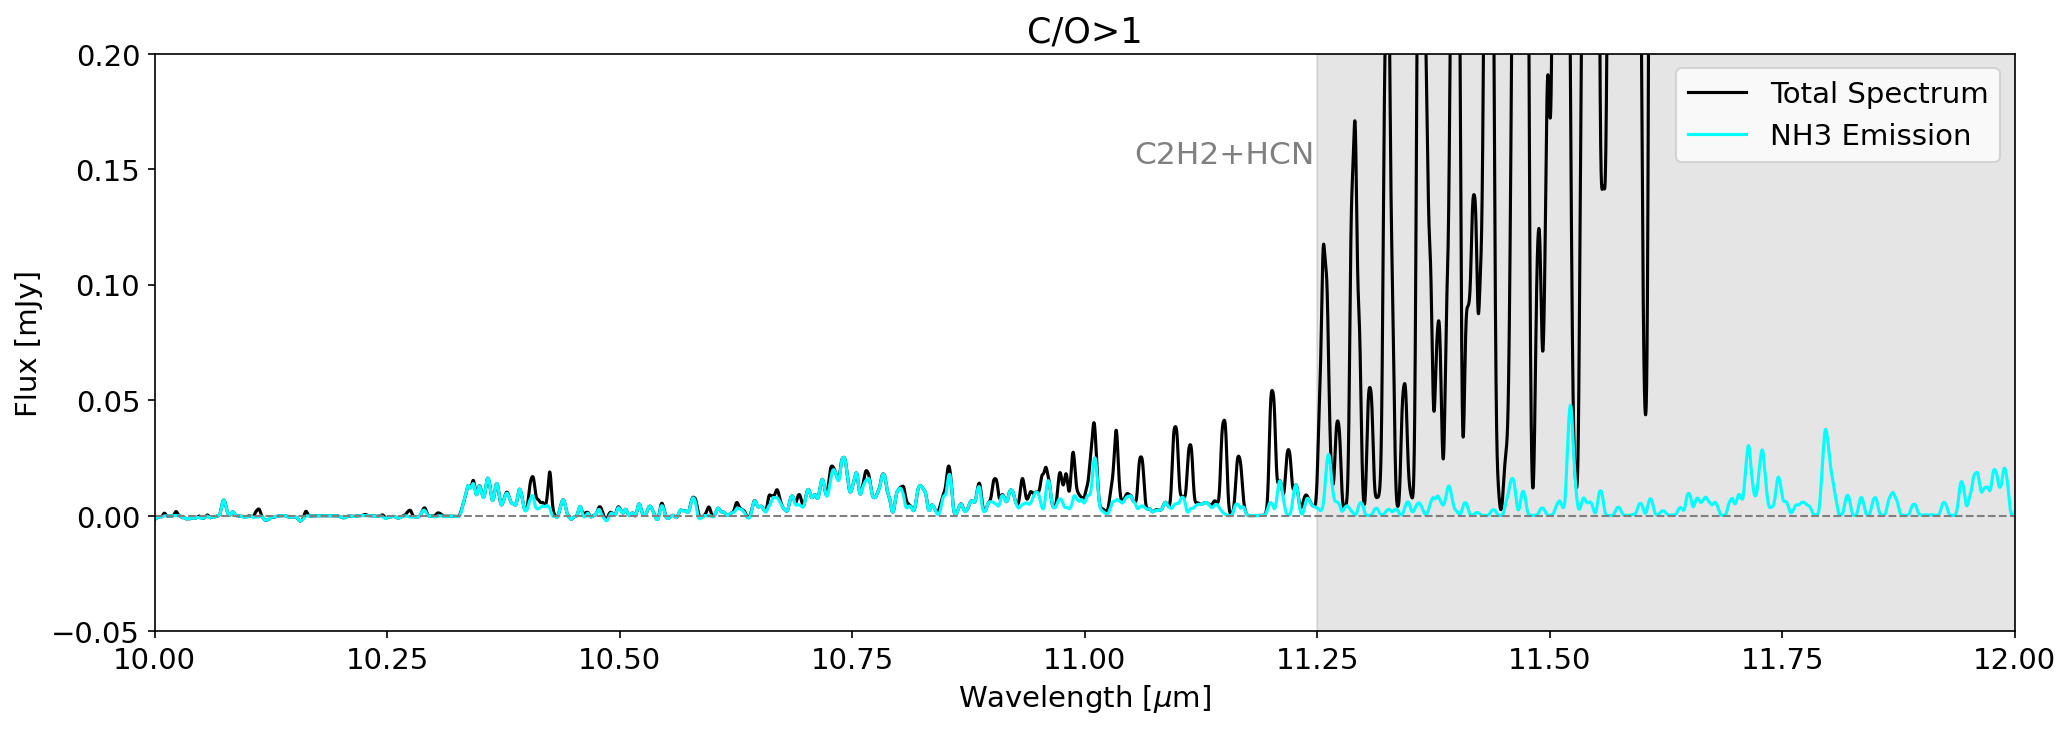

In [126]:
species = ['NH3']
clip_min, clip_max = 10, 12
plt.figure(figsize=(16, 5))
for target in species:
    for i, row in df.iterrows():
        if i != 16:
            continue
        # plt.figure(figsize=(16, 5))

        wavelength = row['FLiTs Wavelength'].copy()
        flux_cont_sub = row['FLiTs Flux'].copy()
        continuum = row['FLiTs Flux Continuum'].copy()

        NH3_wl = row['FLiTs NH3 Wavelength'].copy()
        NH3_flux = row['FLiTs NH3 Flux'].copy()
        NH3_flux = np.interp(wavelength, NH3_wl, NH3_flux)

        flux_cont_sub += NH3_flux
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=np.inf) - continuum

        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']

        plt.plot(wavelength, flux_cont_sub*1000, c='black', label='Total Spectrum')
        plt.plot(real_wl, real_flux*1000, c=colors[target], label=f'{target} Emission')

        plt.title(f'C/O>1')
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.xlim(clip_min, clip_max)
        plt.ylim(-0.05, .2)
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux [mJy]')
        plt.legend(loc='upper right')
        plt.axvspan(11.25, 12, color='grey', alpha=0.2)
        plt.text(11.15, 0.15, 'C2H2+HCN', ha='center', va='bottom', fontsize=15, color='grey')
        plt.savefig('Figures/NH3_region2.pdf', bbox_inches='tight')
plt.show()

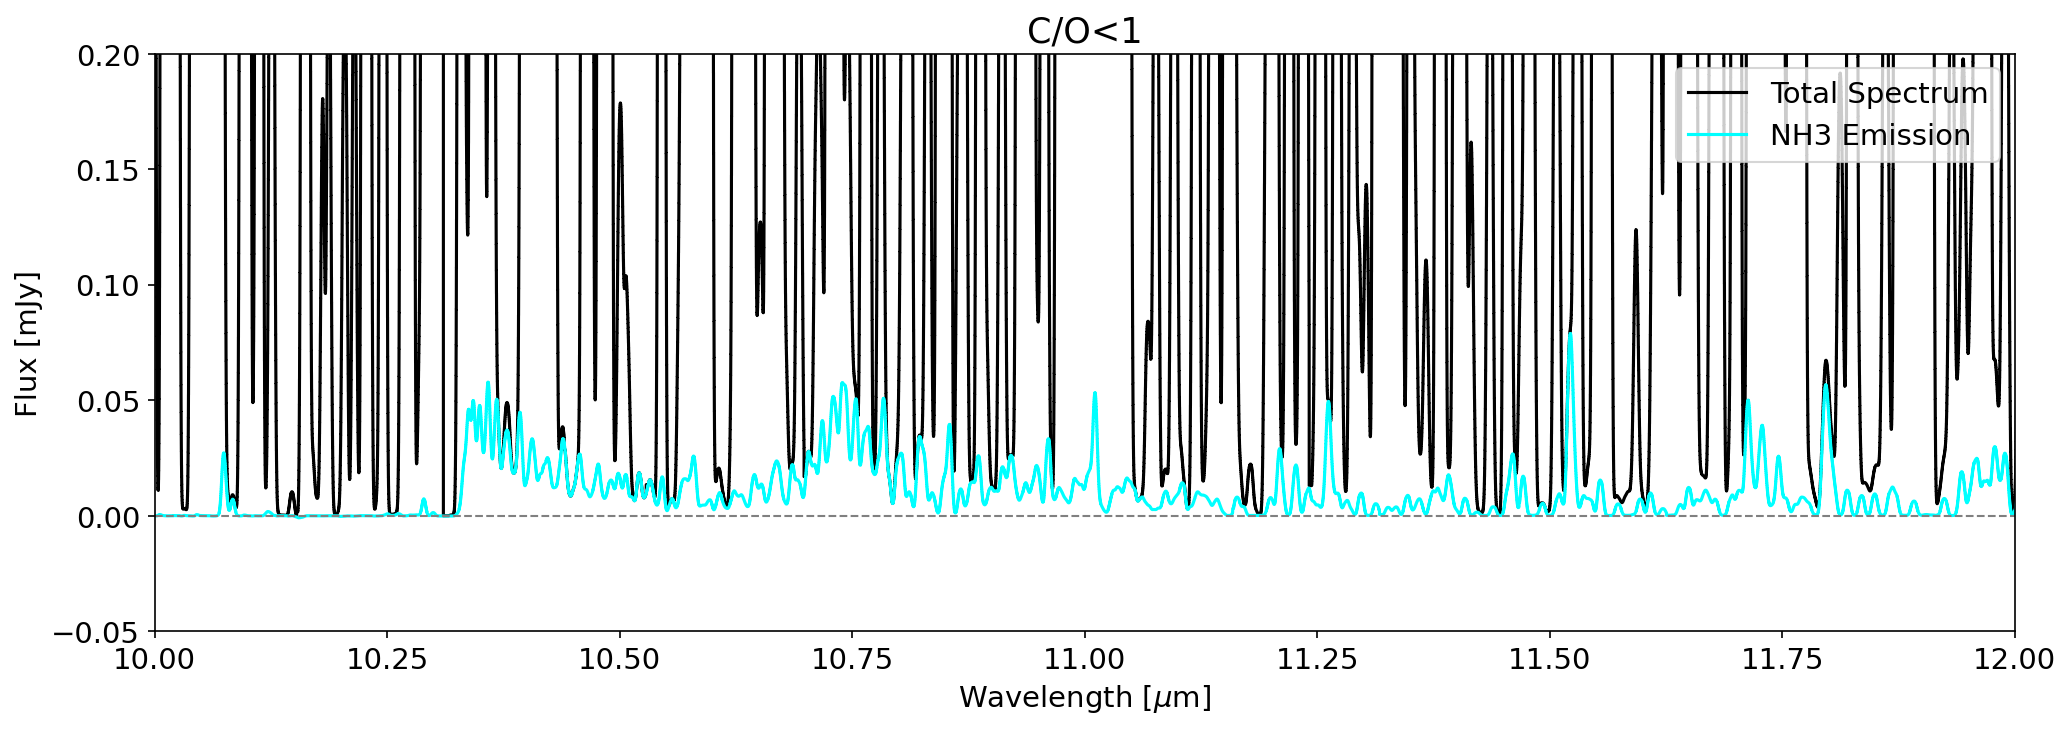

In [239]:
species = ['NH3']
clip_min, clip_max = 10, 12
plt.figure(figsize=(16, 5))
for target in species:
    for i, row in df.iterrows():
        if i != 12:
            continue
        # plt.figure(figsize=(16, 5))

        wavelength = row['FLiTs Wavelength'].copy()
        flux_cont_sub = row['FLiTs Flux'].copy()
        continuum = row['FLiTs Flux Continuum'].copy()

        NH3_wl = row['FLiTs NH3 Wavelength'].copy()
        NH3_flux = row['FLiTs NH3 Flux'].copy()
        NH3_flux = np.interp(wavelength, NH3_wl, NH3_flux)

        flux_cont_sub += NH3_flux
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=np.inf) - continuum

        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']

        plt.step(wavelength, flux_cont_sub*1000, c='black', label='Total Spectrum')
        plt.step(real_wl, real_flux*1000, c=colors[target], label=f'{target} Emission')

        plt.title(f'C/O<1')
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.xlim(clip_min, clip_max)
        plt.ylim(-0.05, .2)
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux [mJy]')
        plt.legend(loc='upper right')
        plt.savefig('Figures/NH3_region3.pdf', bbox_inches='tight')
plt.show()

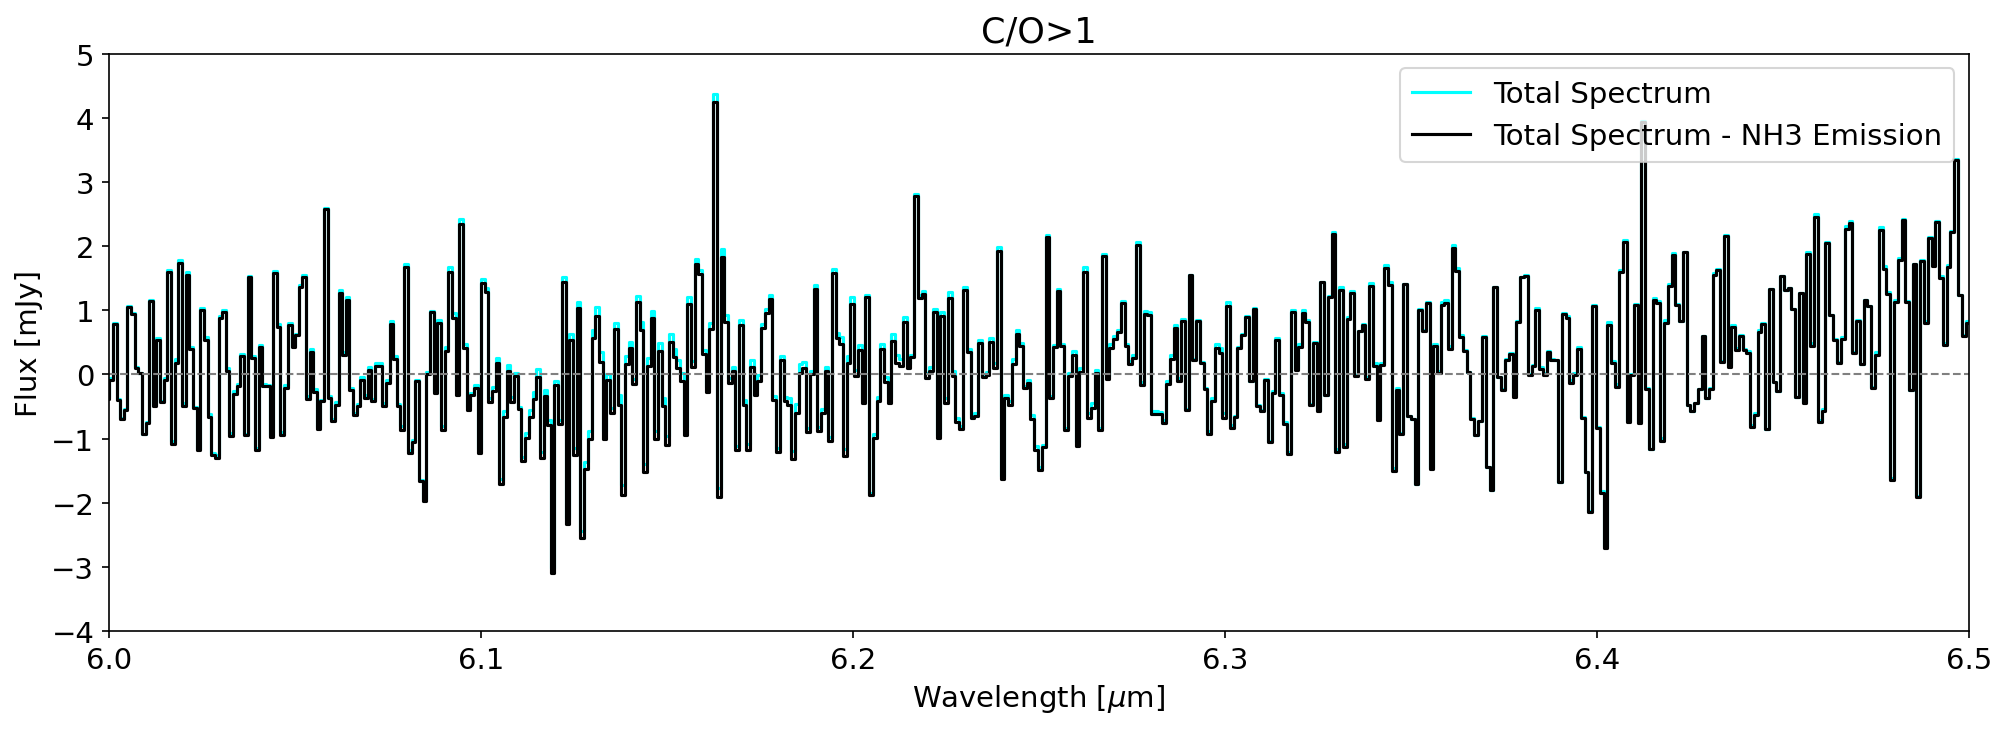

In [241]:
species = ['NH3']
clip_min, clip_max = 6, 6.5
plt.figure(figsize=(16, 5))
for target in species:
    for i, row in df.iterrows():
        if i != 16:
            continue
        # plt.figure(figsize=(16, 5))

        wavelength = row['FLiTs Wavelength'].copy()
        flux_cont_sub = row['FLiTs Flux'].copy()
        continuum = row['FLiTs Flux Continuum'].copy()

        NH3_wl = row['FLiTs NH3 Wavelength'].copy()
        NH3_flux = row['FLiTs NH3 Flux'].copy()
        NH3_flux = np.interp(wavelength, NH3_wl, NH3_flux)

        flux_cont_sub += NH3_flux
        flux_cont_sub = add_noise(flux_cont_sub + continuum, SNR=300) - continuum

        real_wl = row[f'FLiTs {target} Wavelength']
        real_flux = row[f'FLiTs {target} Flux']
        real_flux = np.interp(wavelength, real_wl, real_flux)

        plt.step(wavelength[::50], flux_cont_sub[::50]*1000, c=colors[target], label=f'Total Spectrum')
        plt.step(wavelength[::50], (flux_cont_sub-real_flux)[::50]*1000, c='black', label=f'Total Spectrum - {target} Emission')


        plt.title(f'C/O>1')
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.xlim(clip_min, clip_max)
        plt.ylim(-4, 5)
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux [mJy]')
        plt.legend(loc='upper right')
        plt.savefig('Figures/AddNoise.pdf', bbox_inches='tight')
plt.show()